# 1. Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)

In [1]:
#!pip install DiadFit --upgrade 

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.38'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'

In [4]:
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files[0:5]

['Ne_lines_12_2.txt',
 'Ne_lines_1_1.txt',
 'Ne_lines_1_2.txt',
 'Ne_lines_2_1.txt',
 'Ne_lines_2_2.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.02 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
1           819.618059     5000.0                556.27662
9          1118.005523     5000.0                565.66588
16         1311.398741     5000.0                571.92248
19         1399.833669     5000.0                574.82985
23         1448.483158     7000.0                576.44188

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1118
line_2=1448
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  330.477634  1118.005523  1448.483158                1118   

   Entered Pos Line 2  
0                1448

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[3] 
print(filename)

Ne_lines_2_1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height  Peak2_cent  Peak2_height  Peak1_prom  Peak2_prom
71     1117.29       11743.0     1448.29       64525.0     11332.8     64114.8

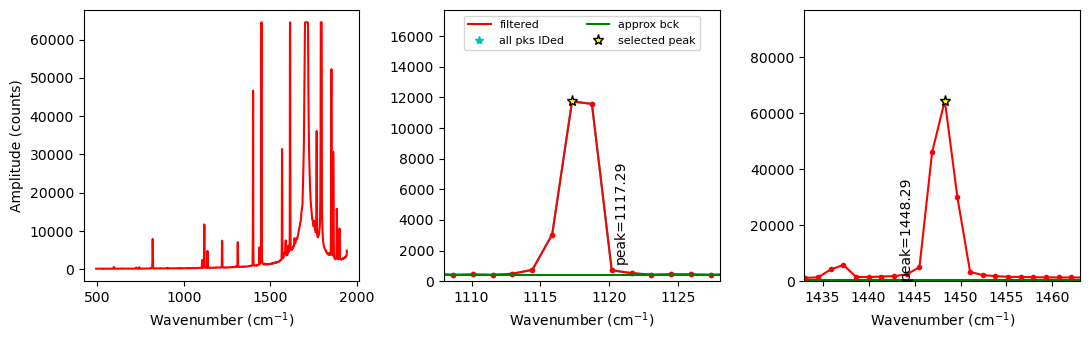

In [8]:
exclude_range_1=None
exclude_range_2=None


Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [28]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=1, LH_offset_mini=[2, 5],
pk1_sigma=1.5, pk2_sigma=1.5, y_range_baseline_pk1=500, y_range_baseline_pk2=5000,
lower_bck_pk1=(-80, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -20], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=15, x_span_pk1=[-5, 5], x_span_pk2=[-5, 5],
N_poly_pk2_baseline=2 )

filename  pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  \
0  Ne_lines_2_1.txt    1448.044886  200967.997794    1.42747      None   

   error_pk2  Peak2_Prop_Lor  pk1_peak_cent  pk1_amplitude  pk1_sigma  \
0          1    1.295672e-09    1117.964548   39894.239538   1.128511   

  pk1_gamma  error_pk1  Peak1_Prop_Lor     deltaNe   Ne_Corr  Ne_Corr_min  \
0      None     0.0435        0.276156  330.080338  1.001204     0.998048   

   Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  
0     1.004379    1674.83561    426.178484       2101.014095

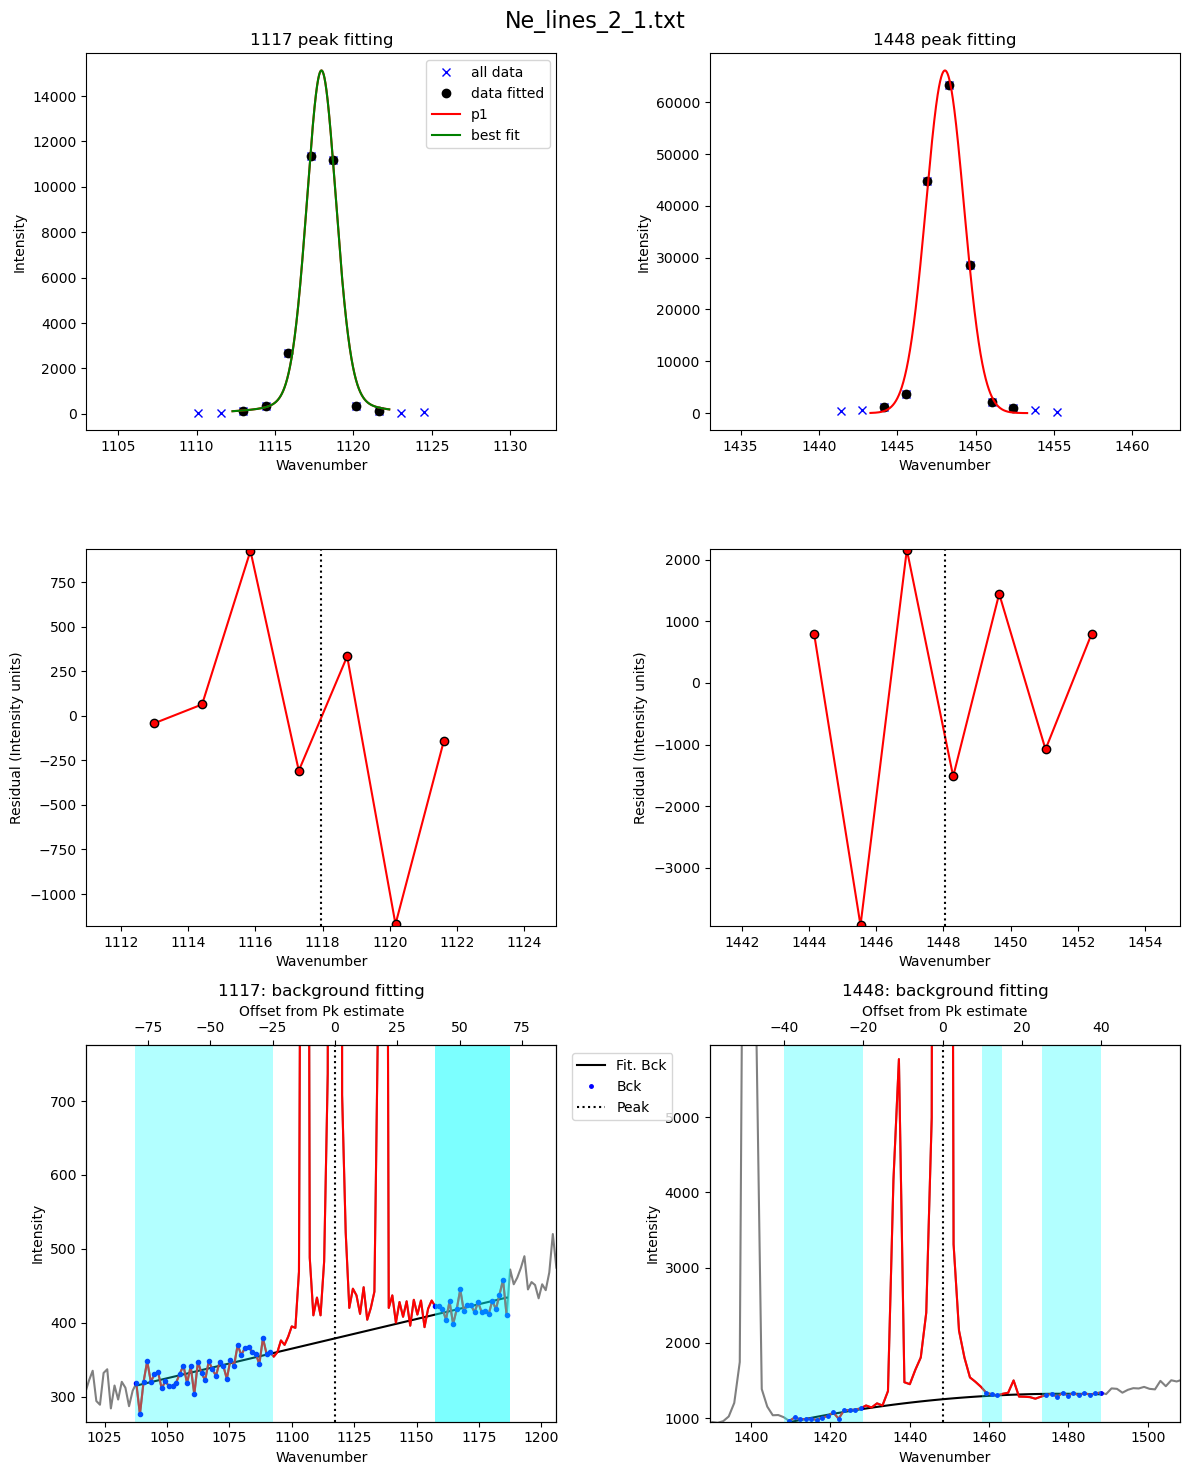

In [29]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=False,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[i], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[i],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[i],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[i],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [30]:
## Update sigma based on this one fit
Ne_Config_tweak=Ne_Config_est
Ne_Config_tweak.pk1_sigma=df_test_params['pk1_sigma'].iloc[0]
Ne_Config_tweak.pk2_sigma=df_test_params['pk2_sigma'].iloc[0]

## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:18<00:03,  1.09it/s]g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\ne_lines.py:1057: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ((ax3, ax2), (ax5, ax4), (ax1, ax0)) = plt.subplots(3,2, figsize = (12,15)) # adjust dimensions of figure here
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:22<00:00,  1.09it/s]


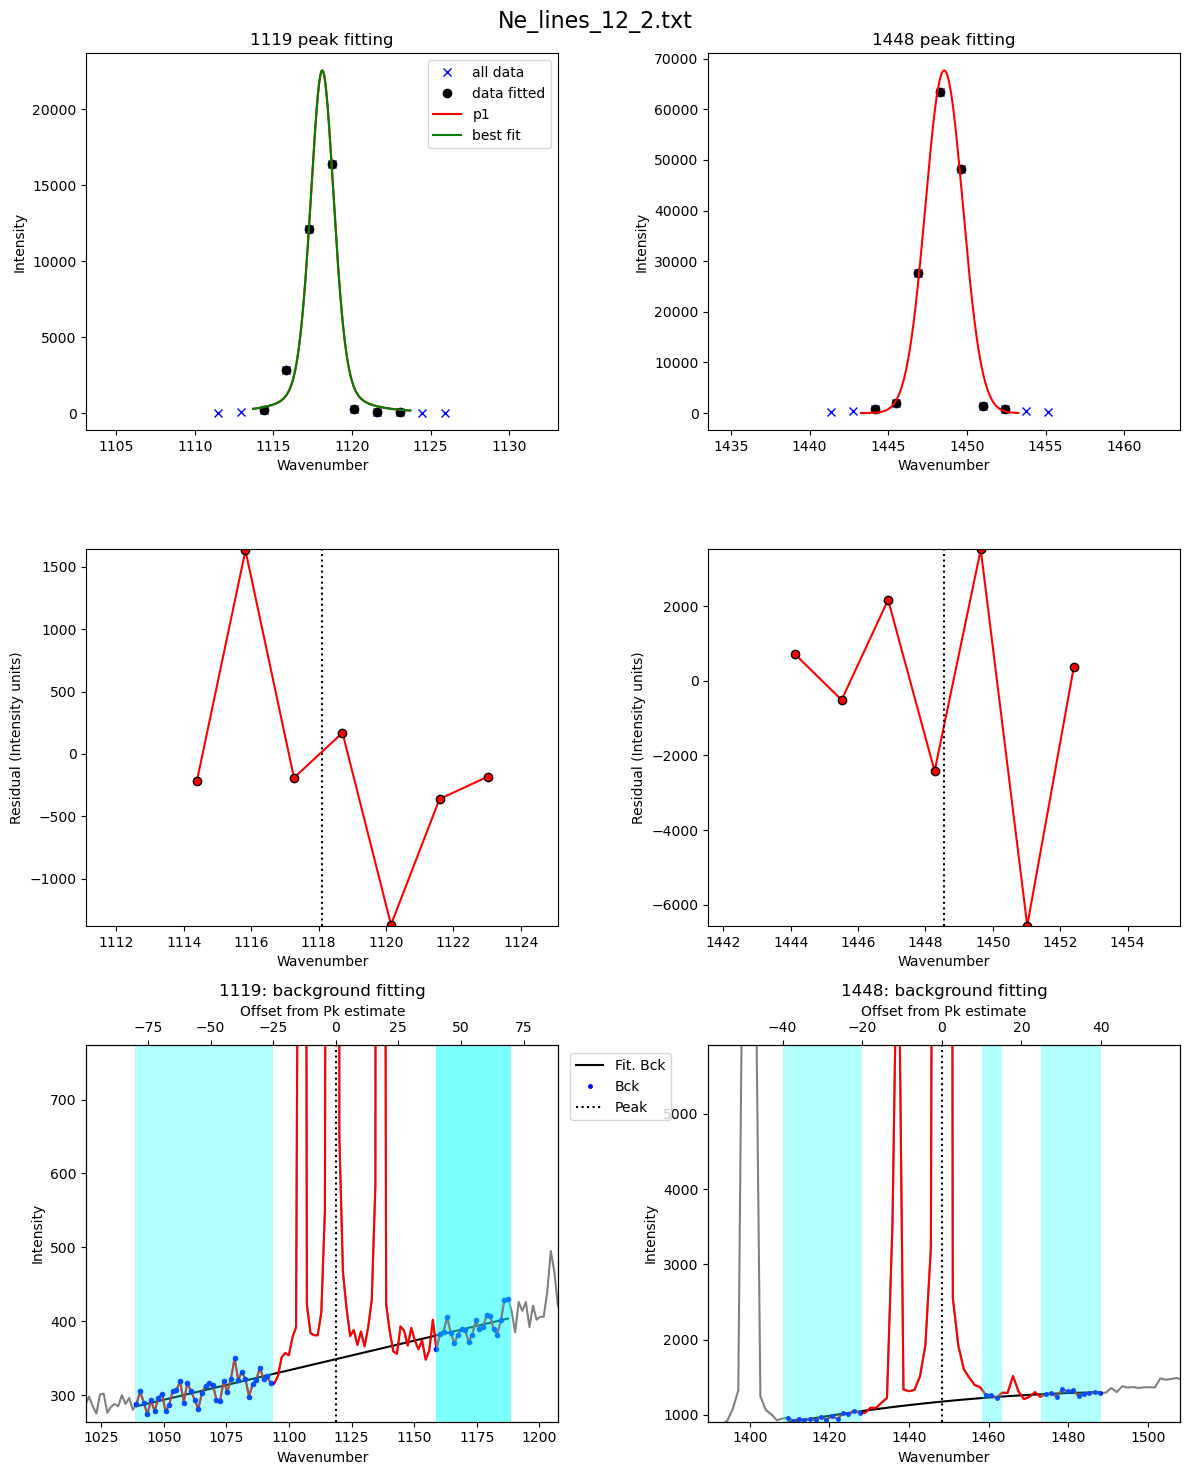

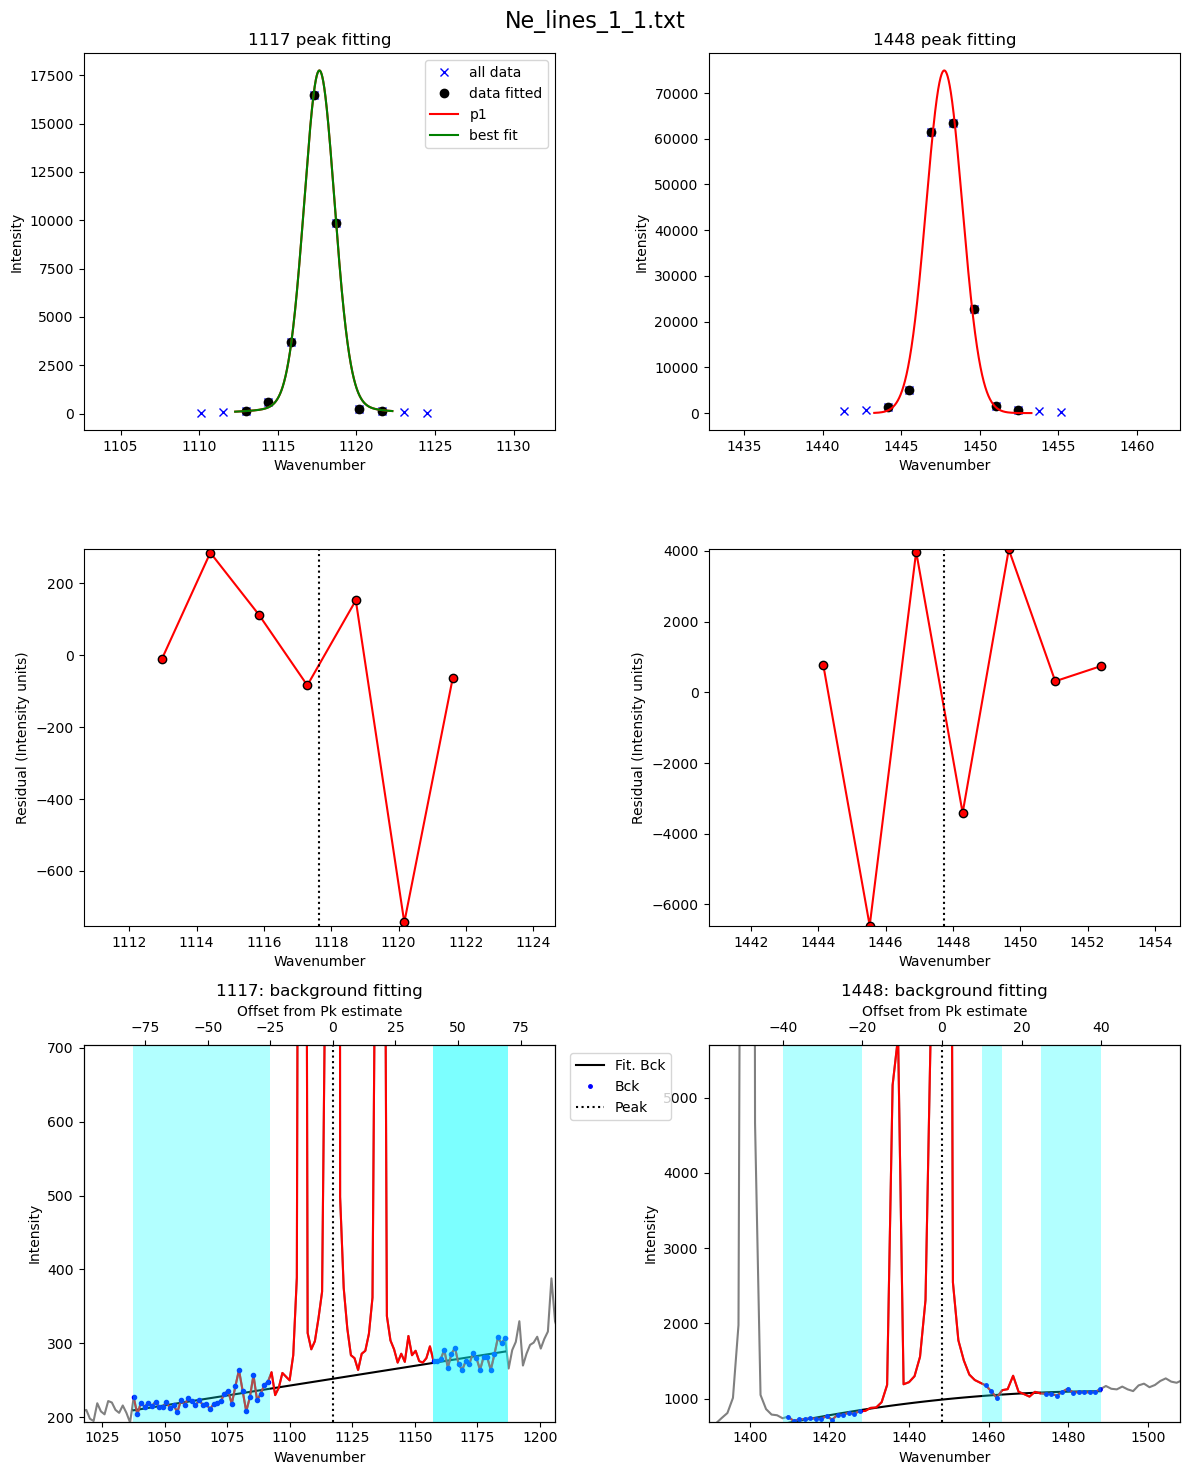

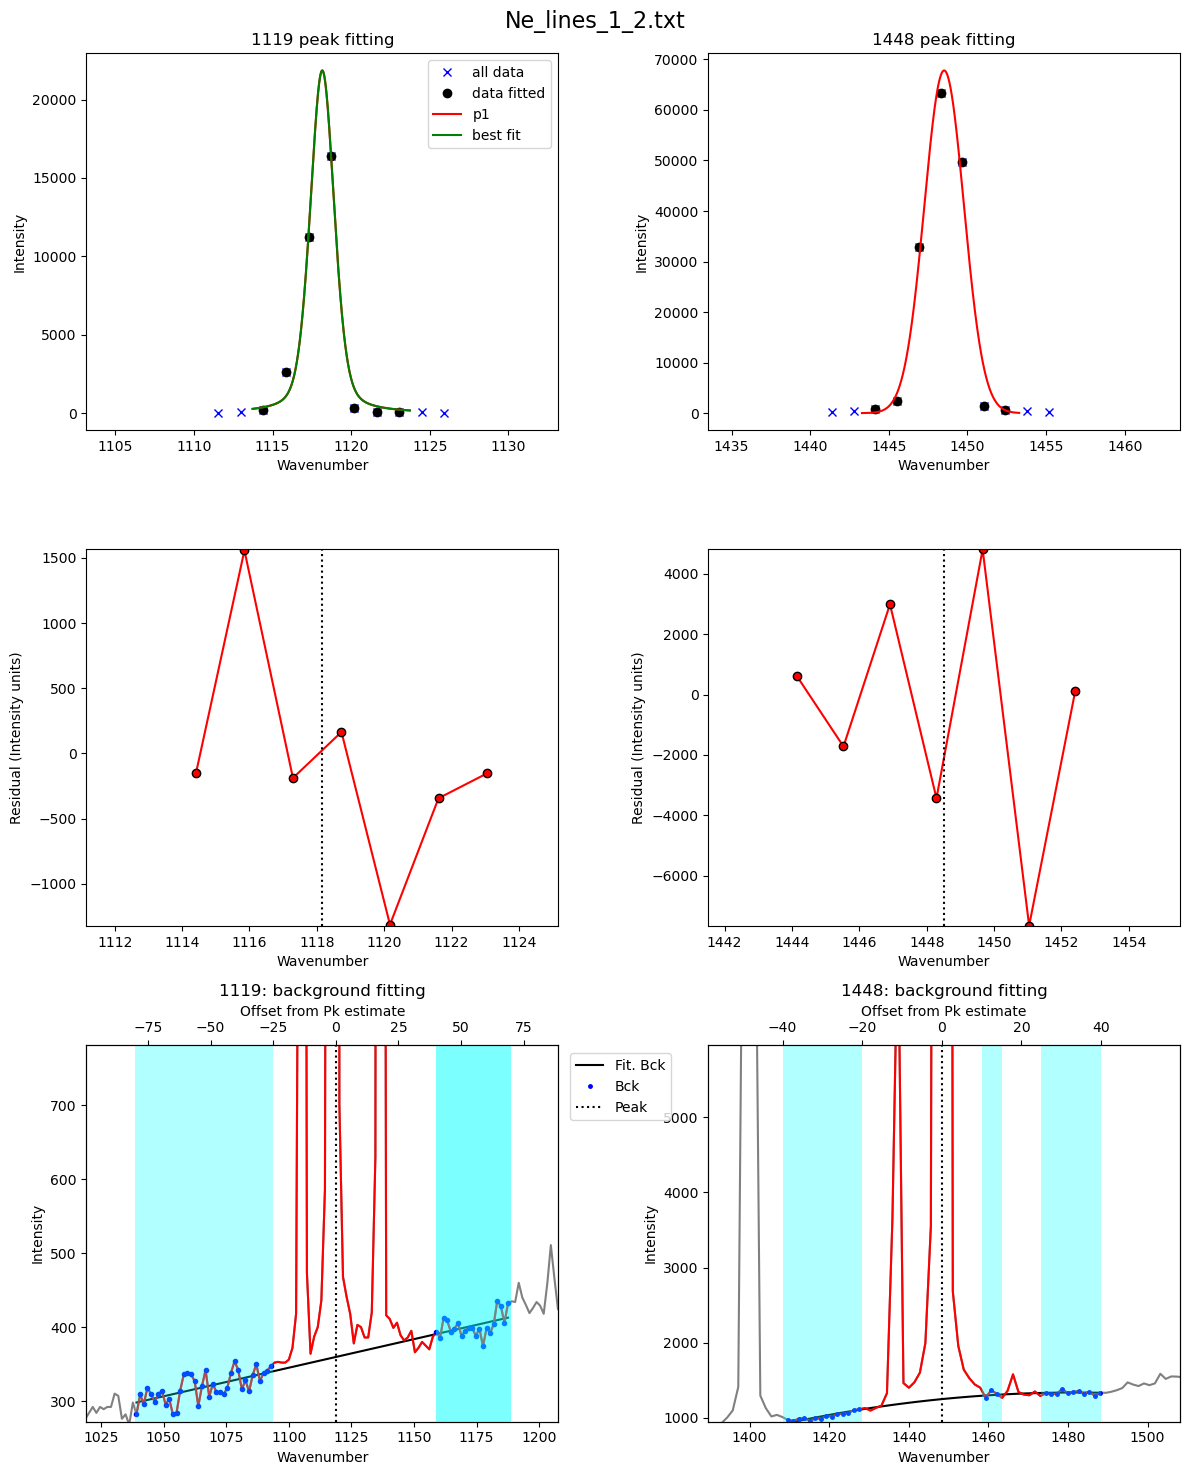

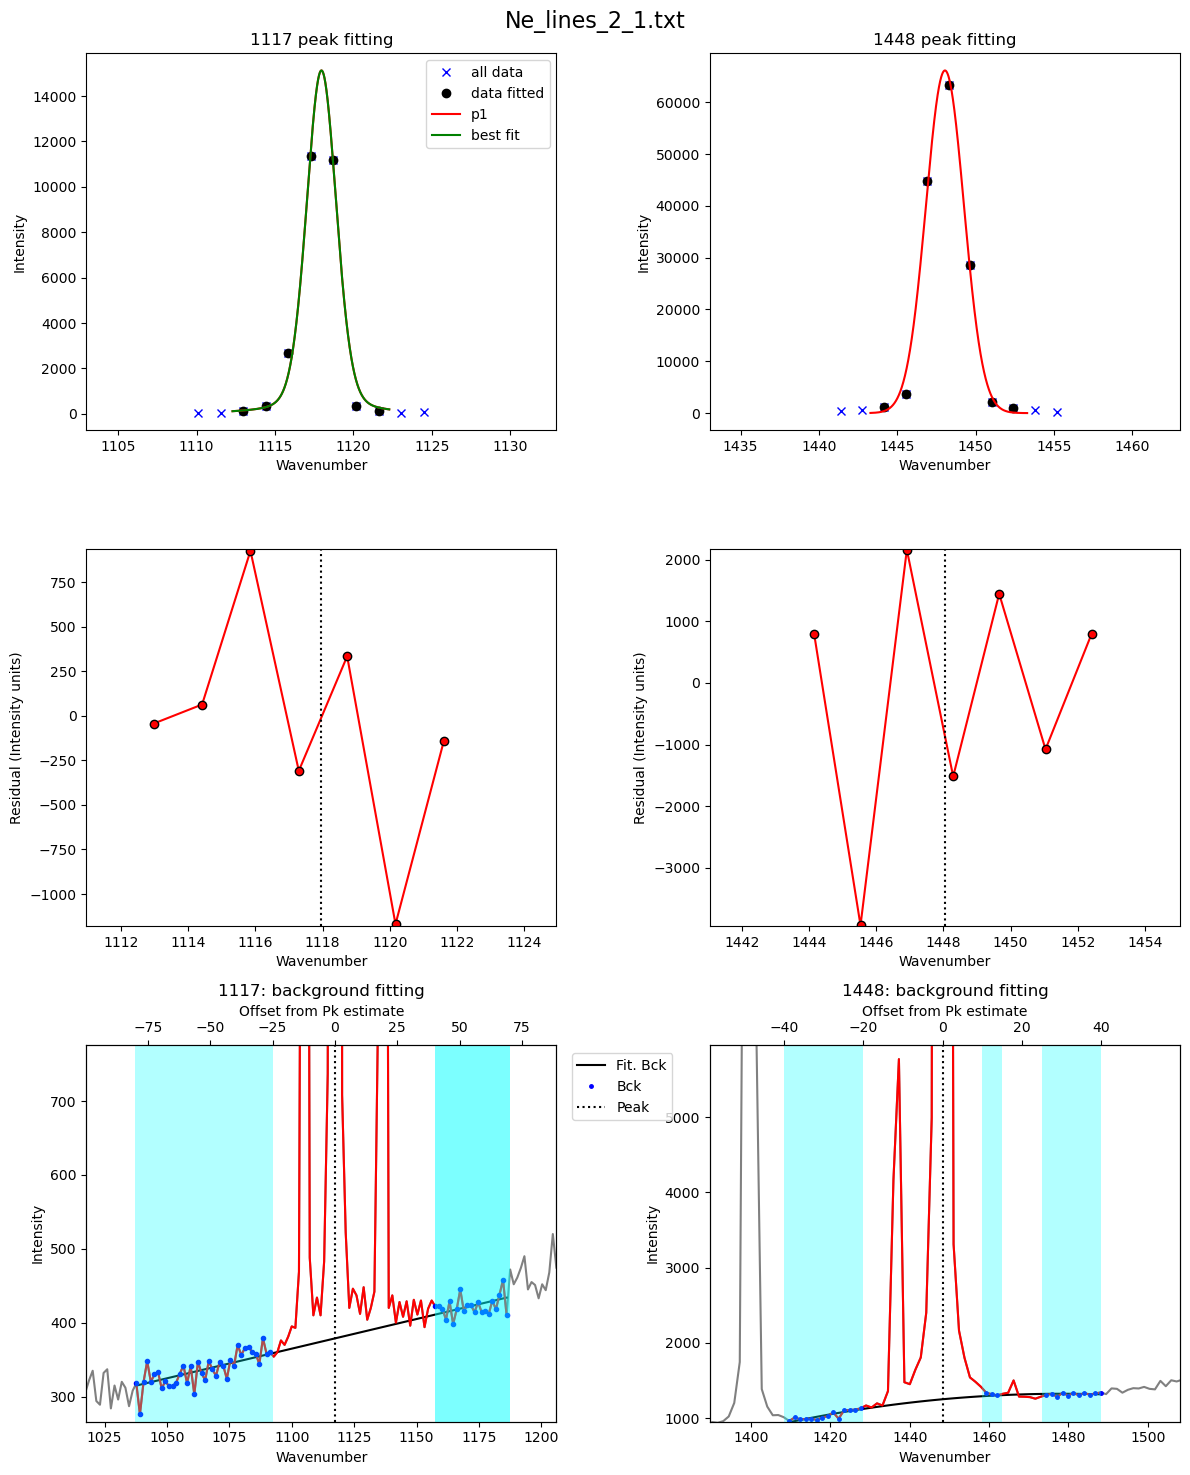

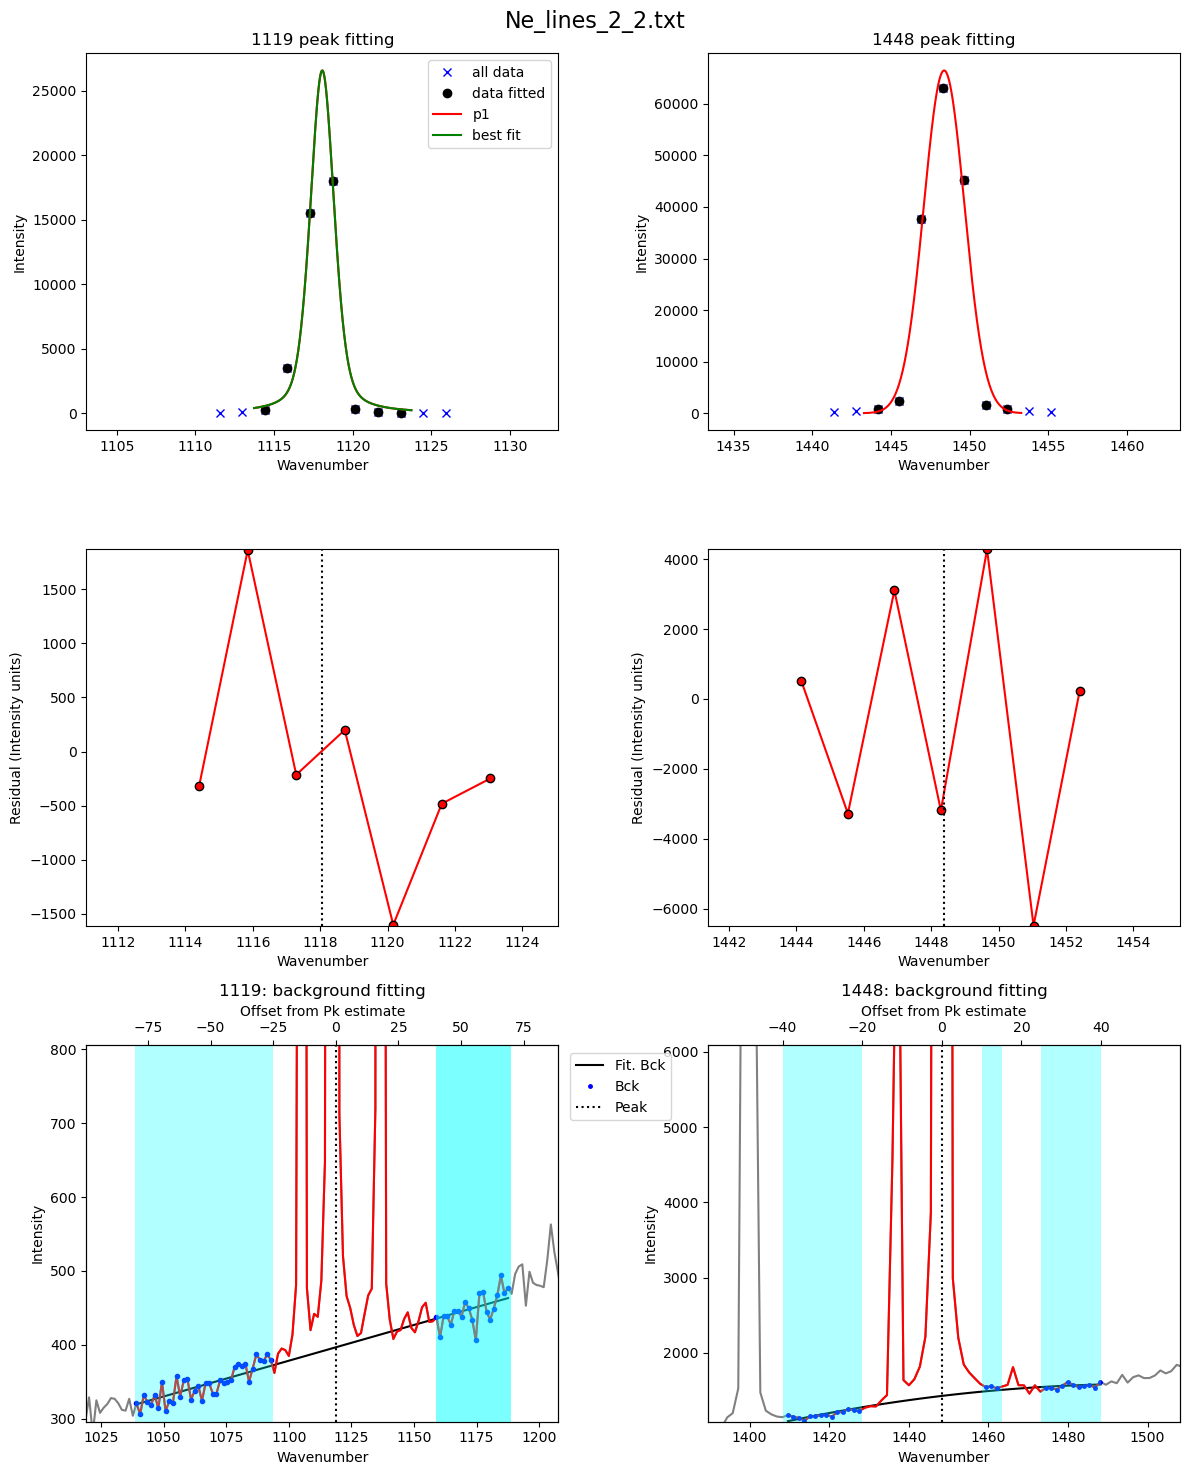

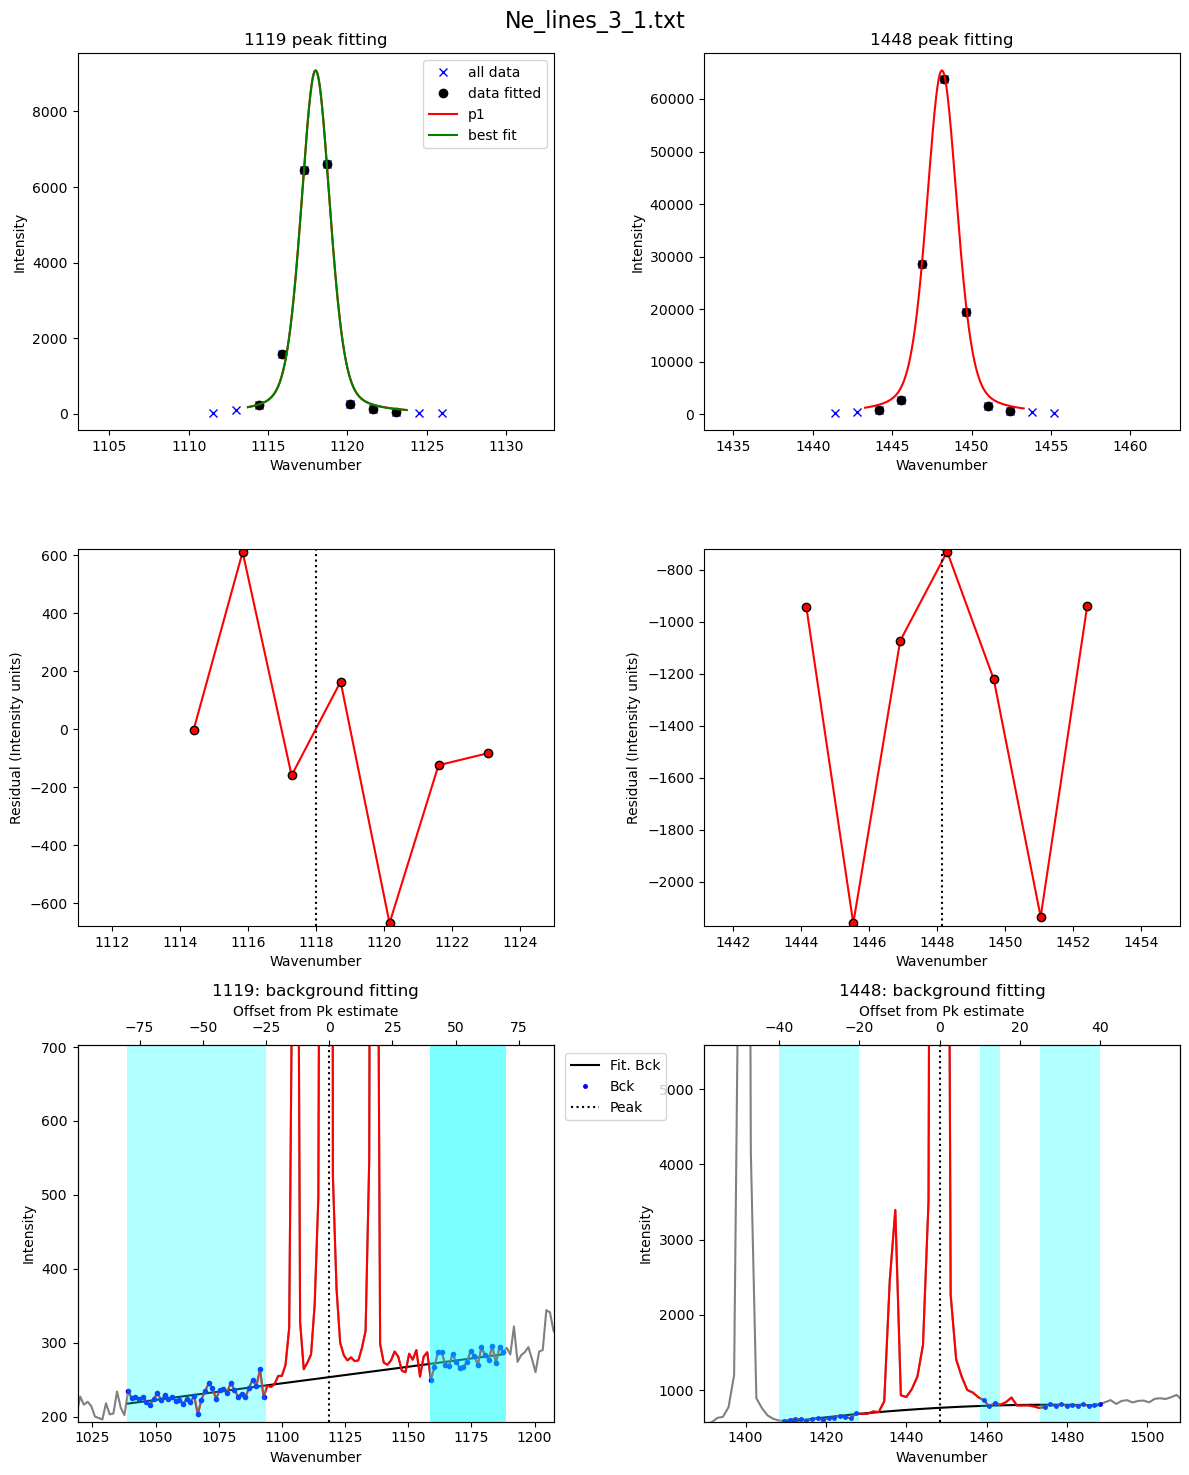

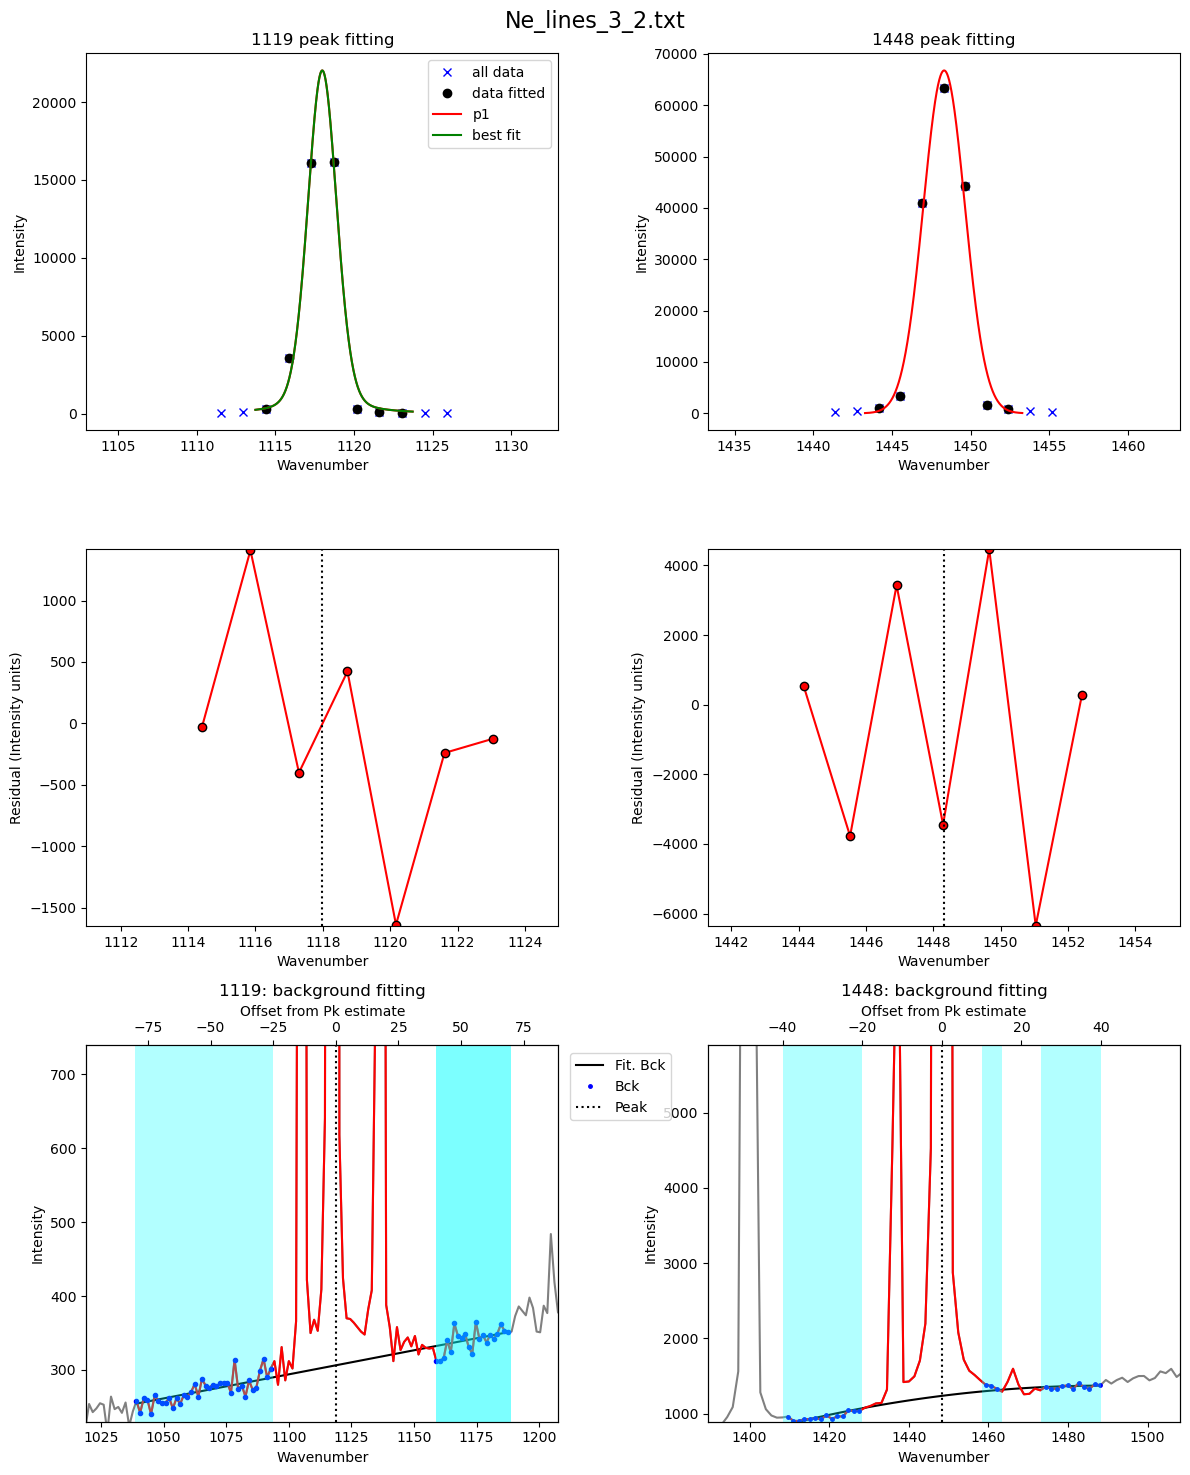

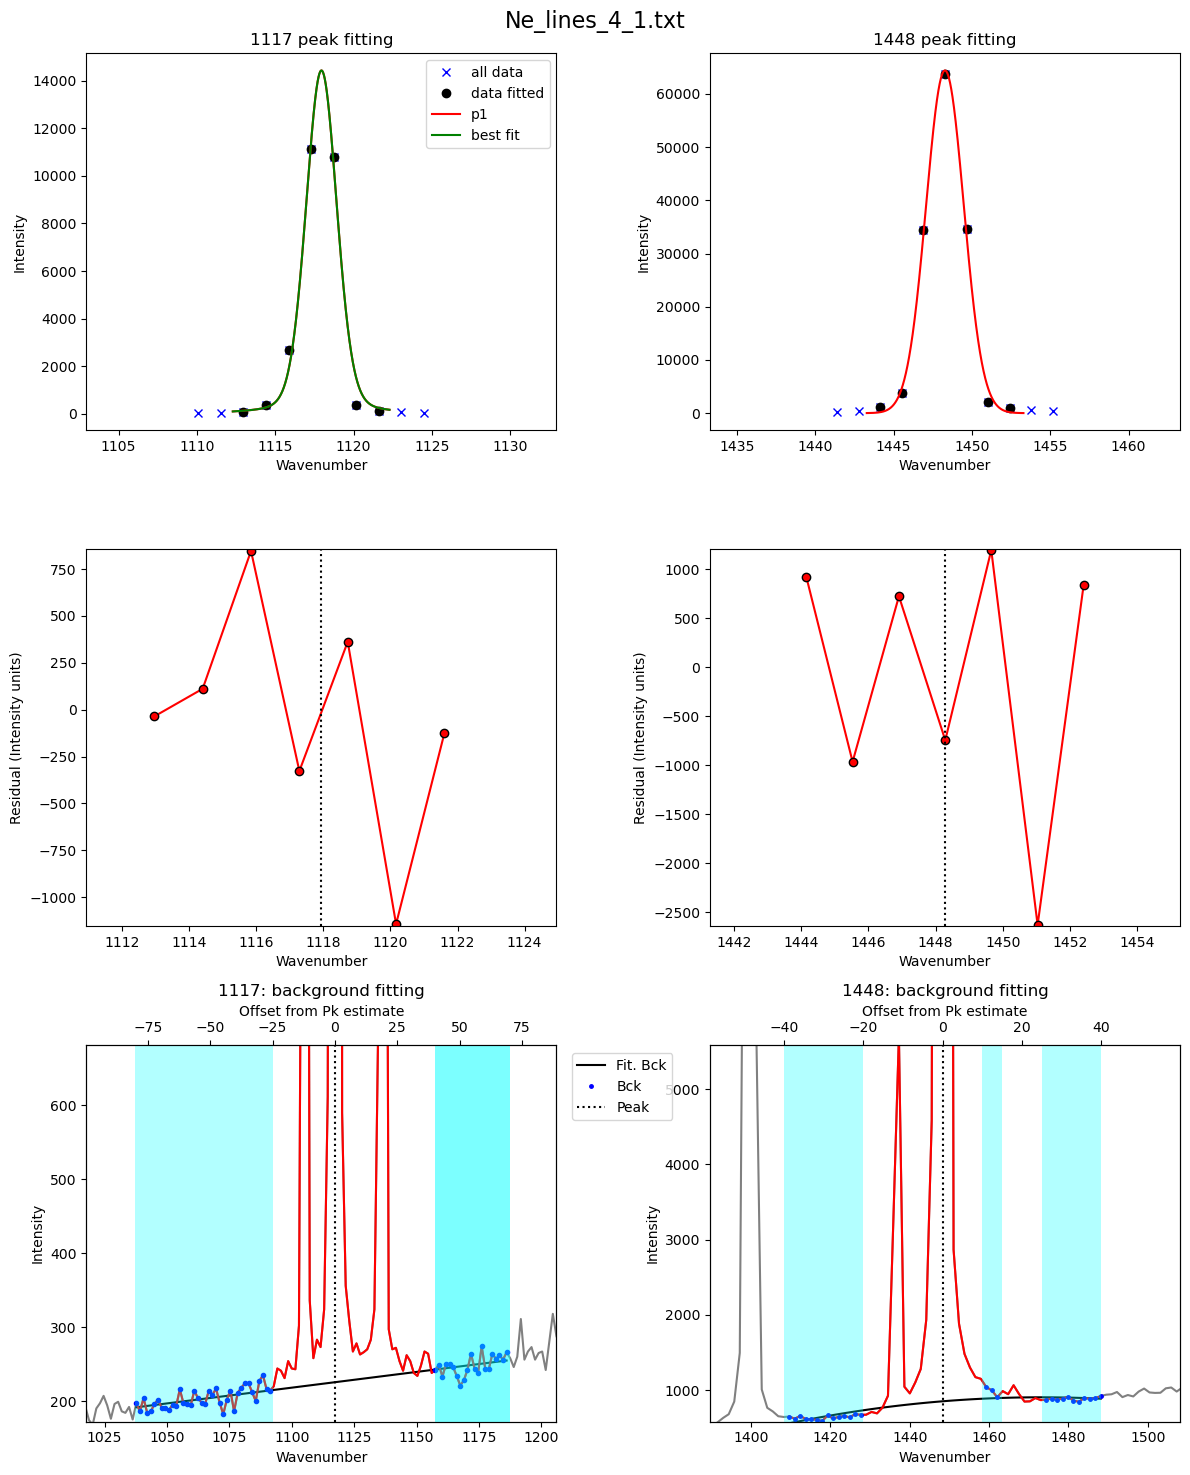

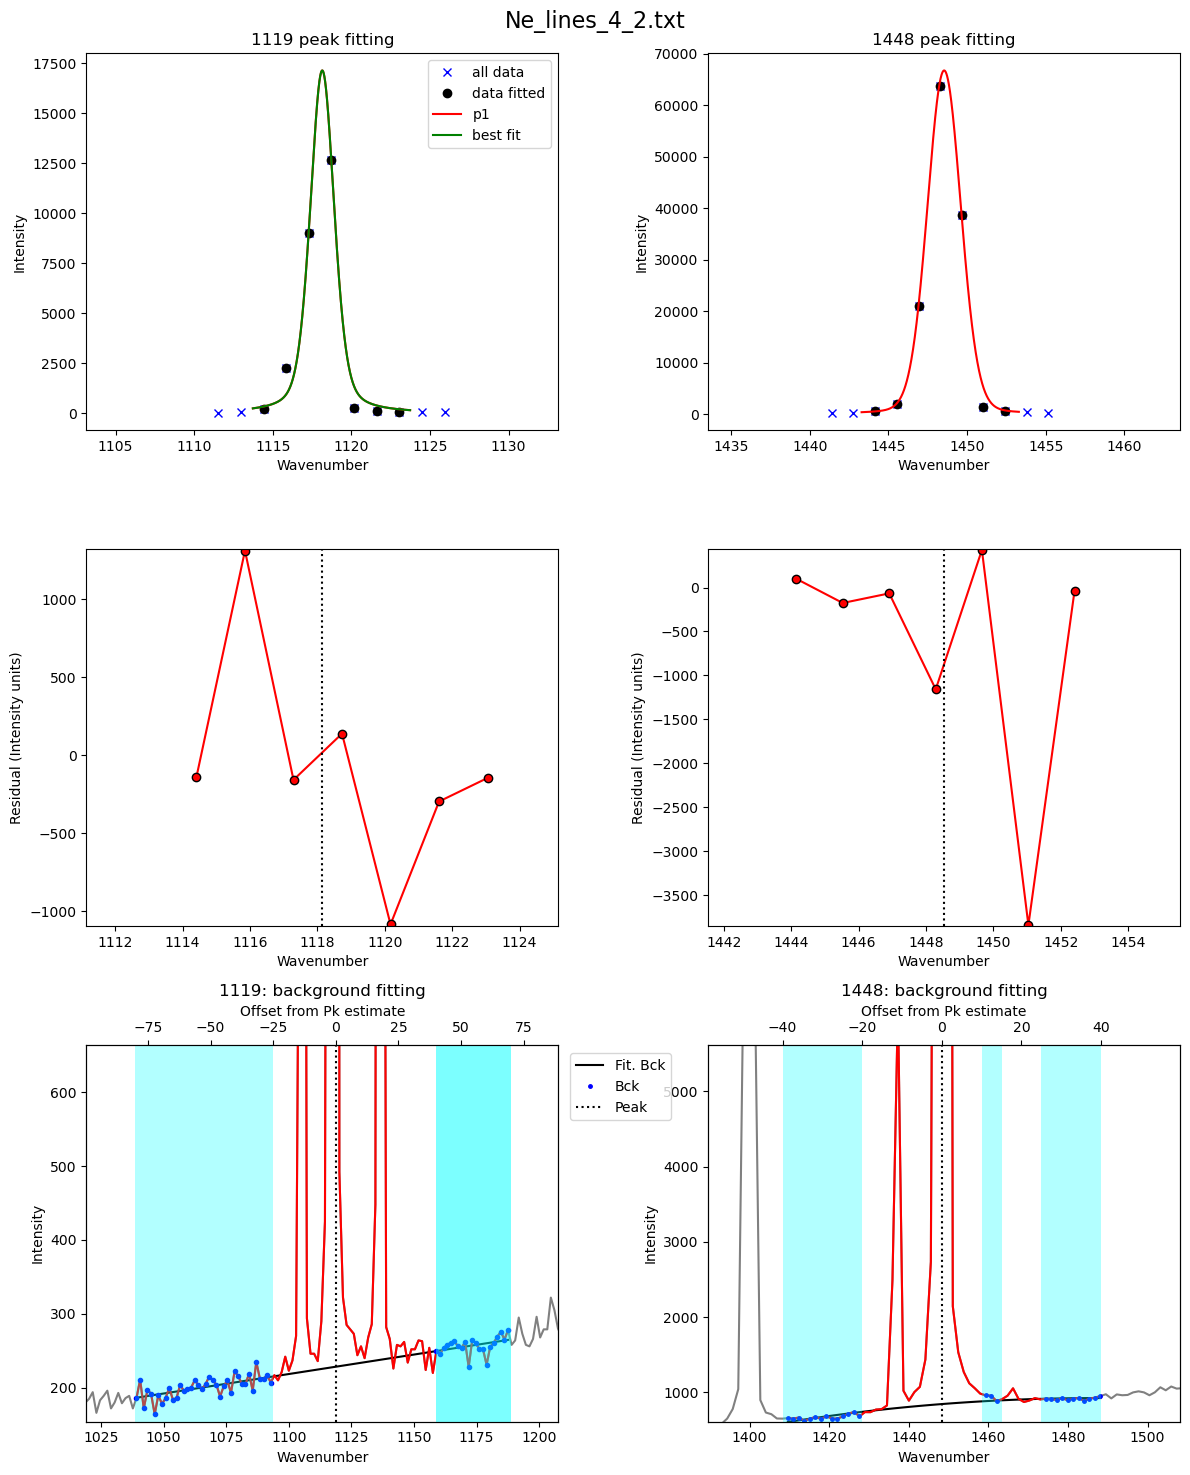

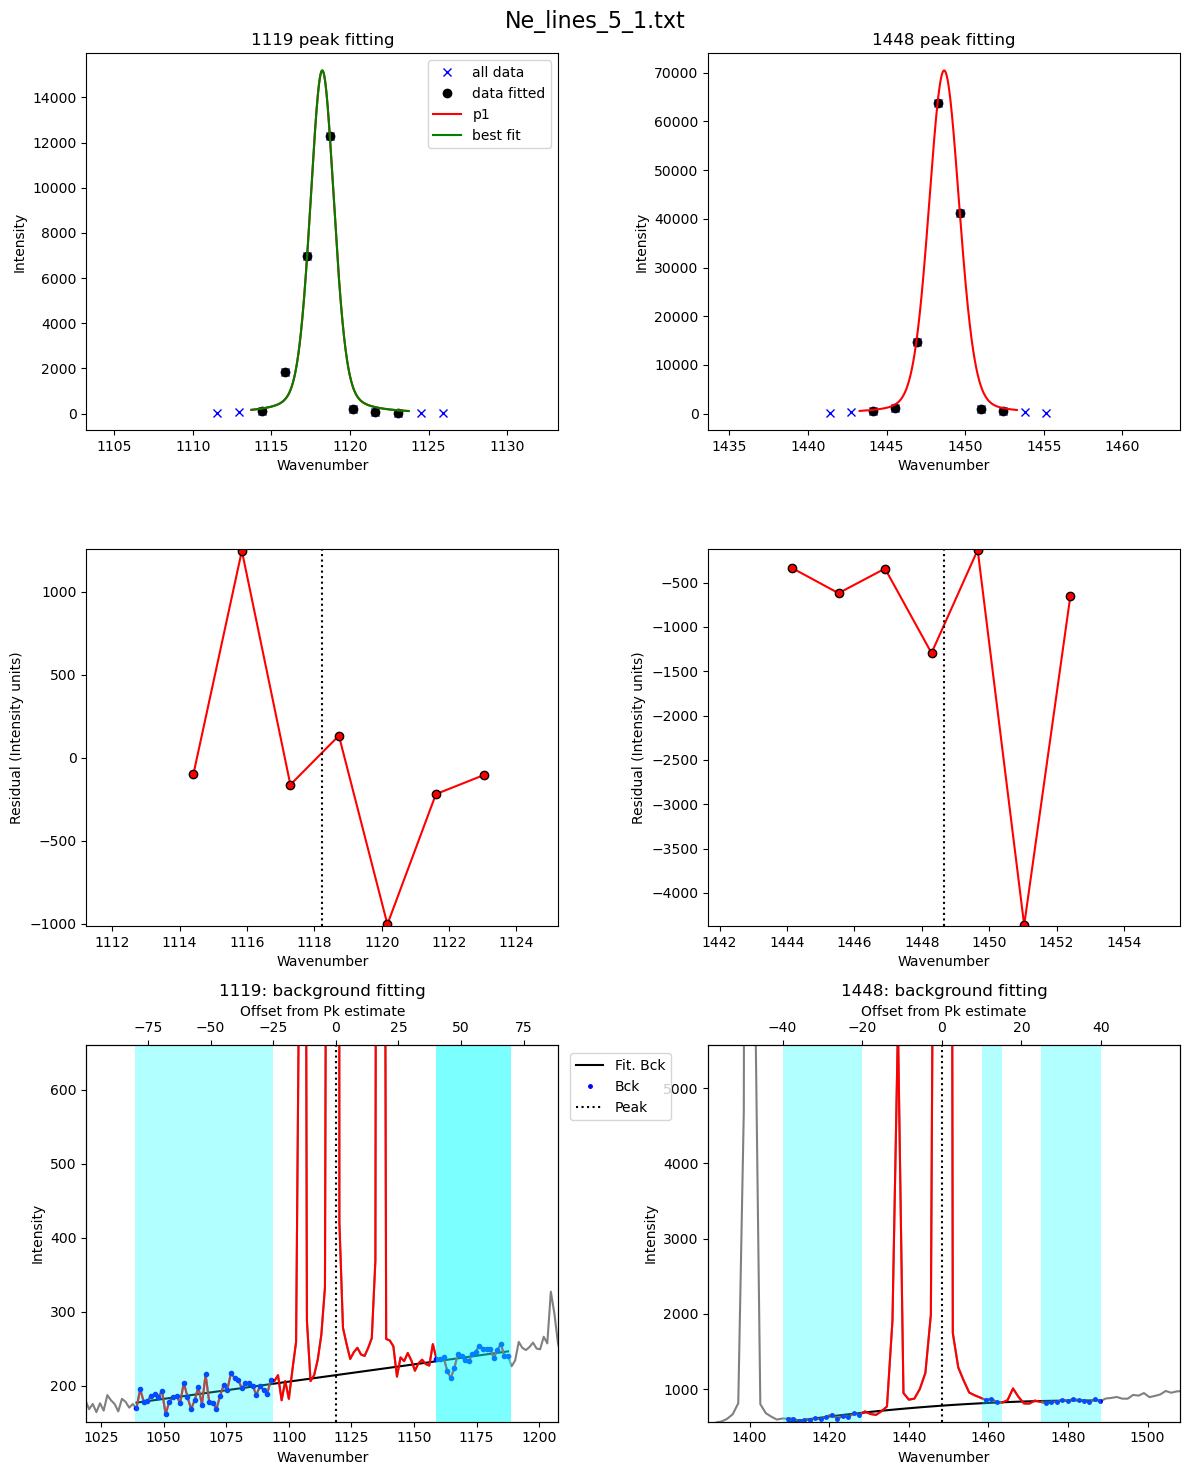

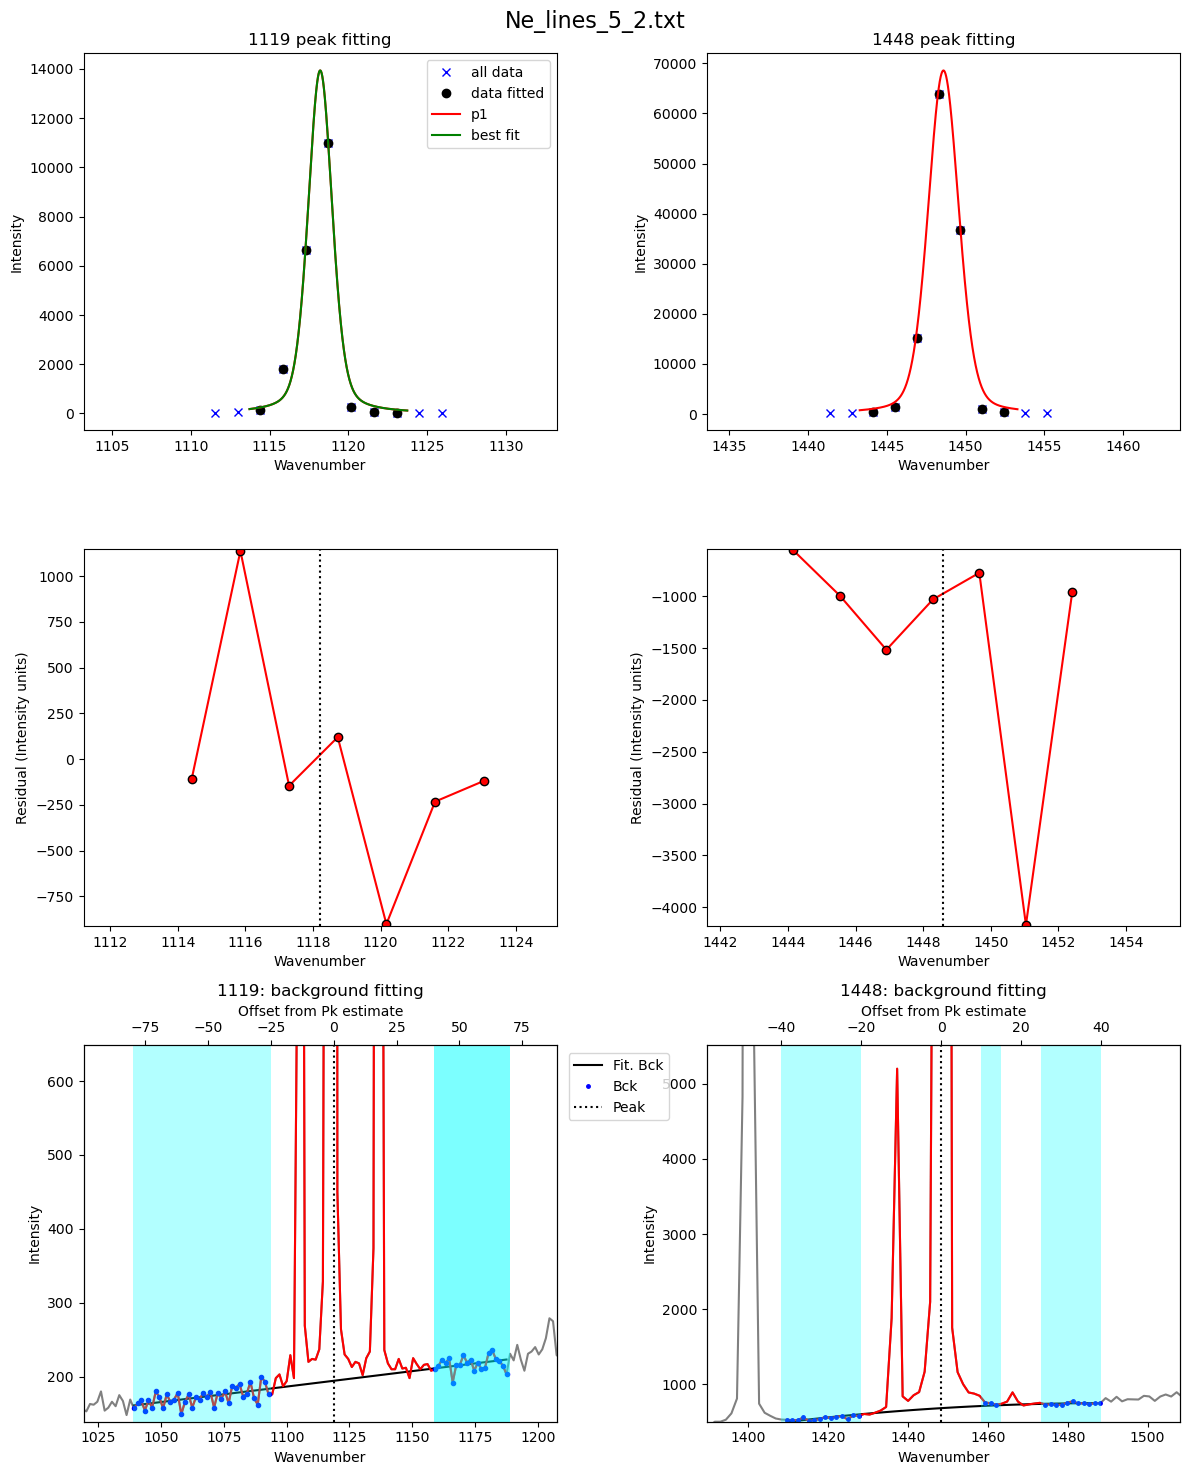

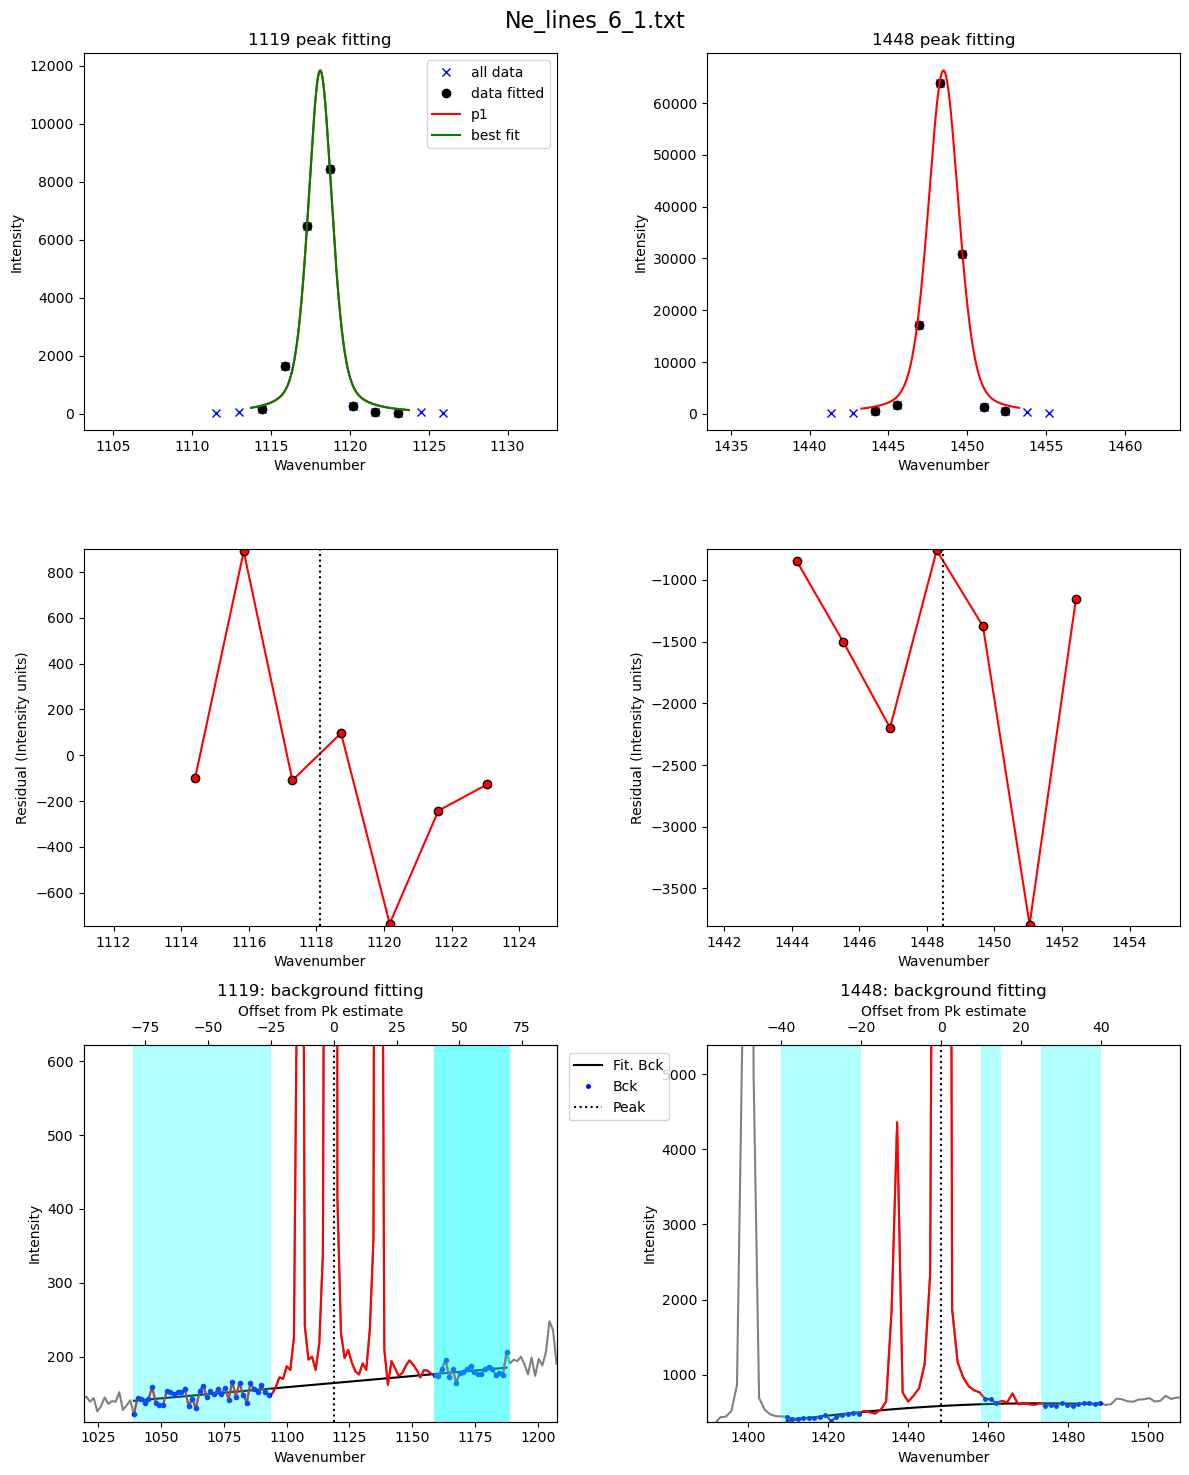

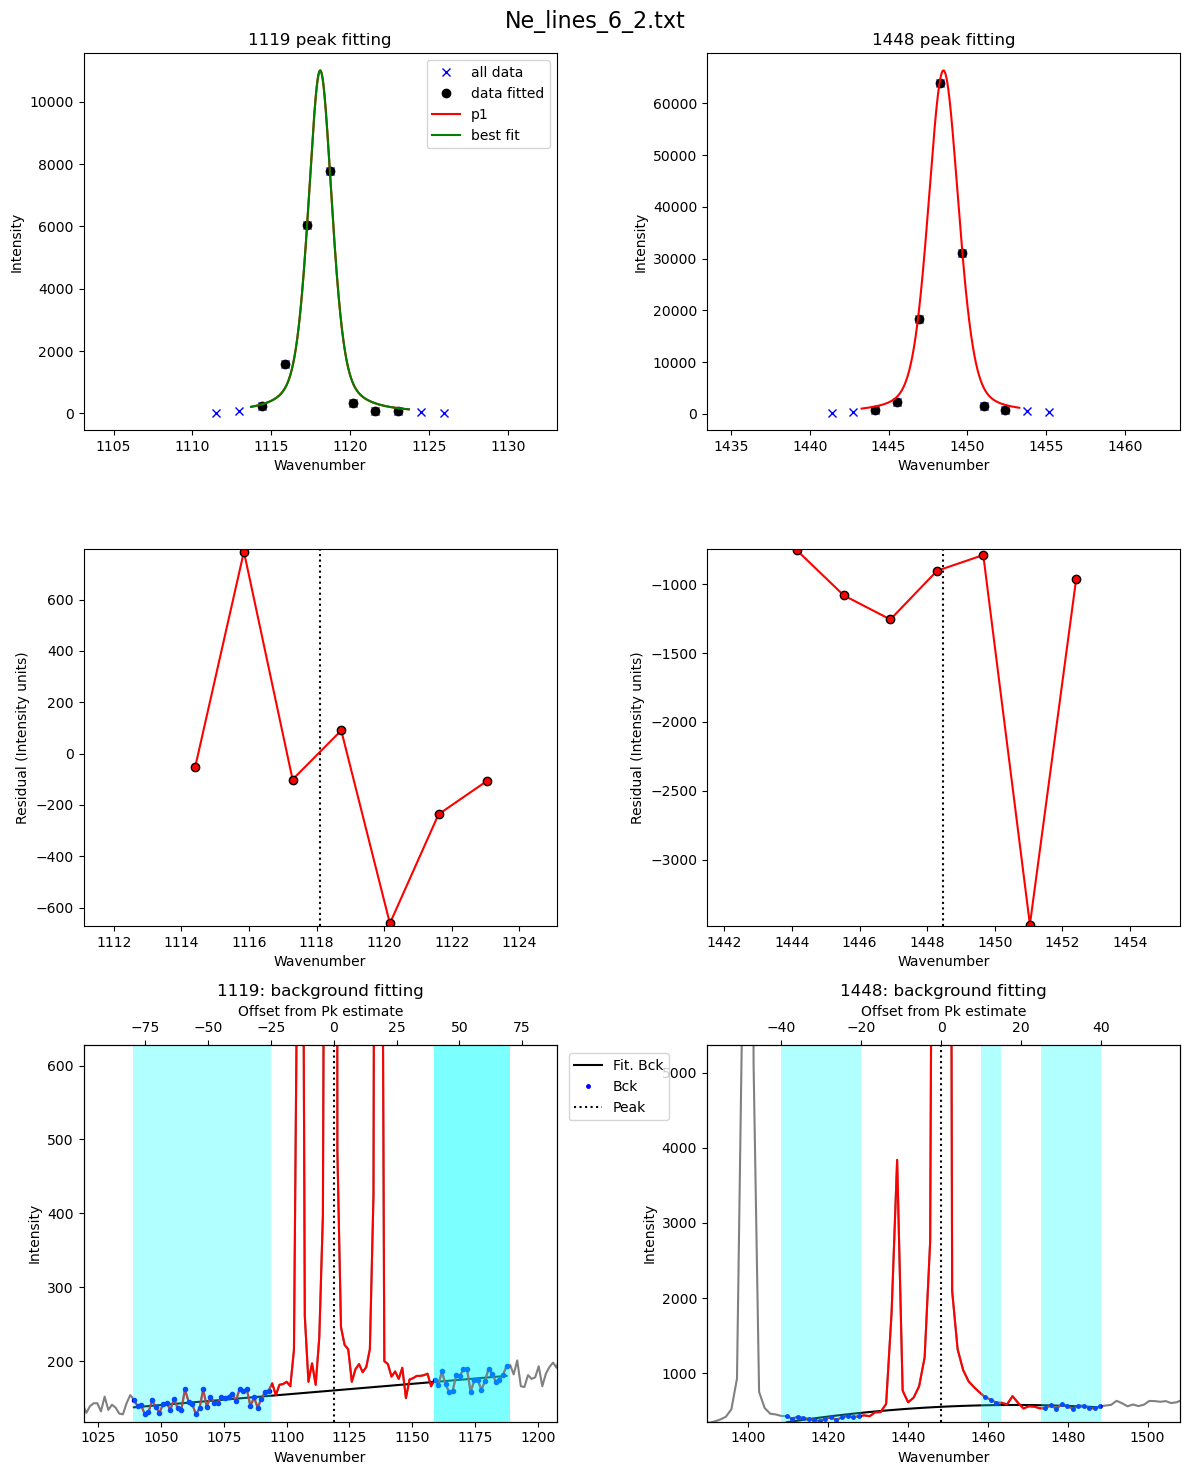

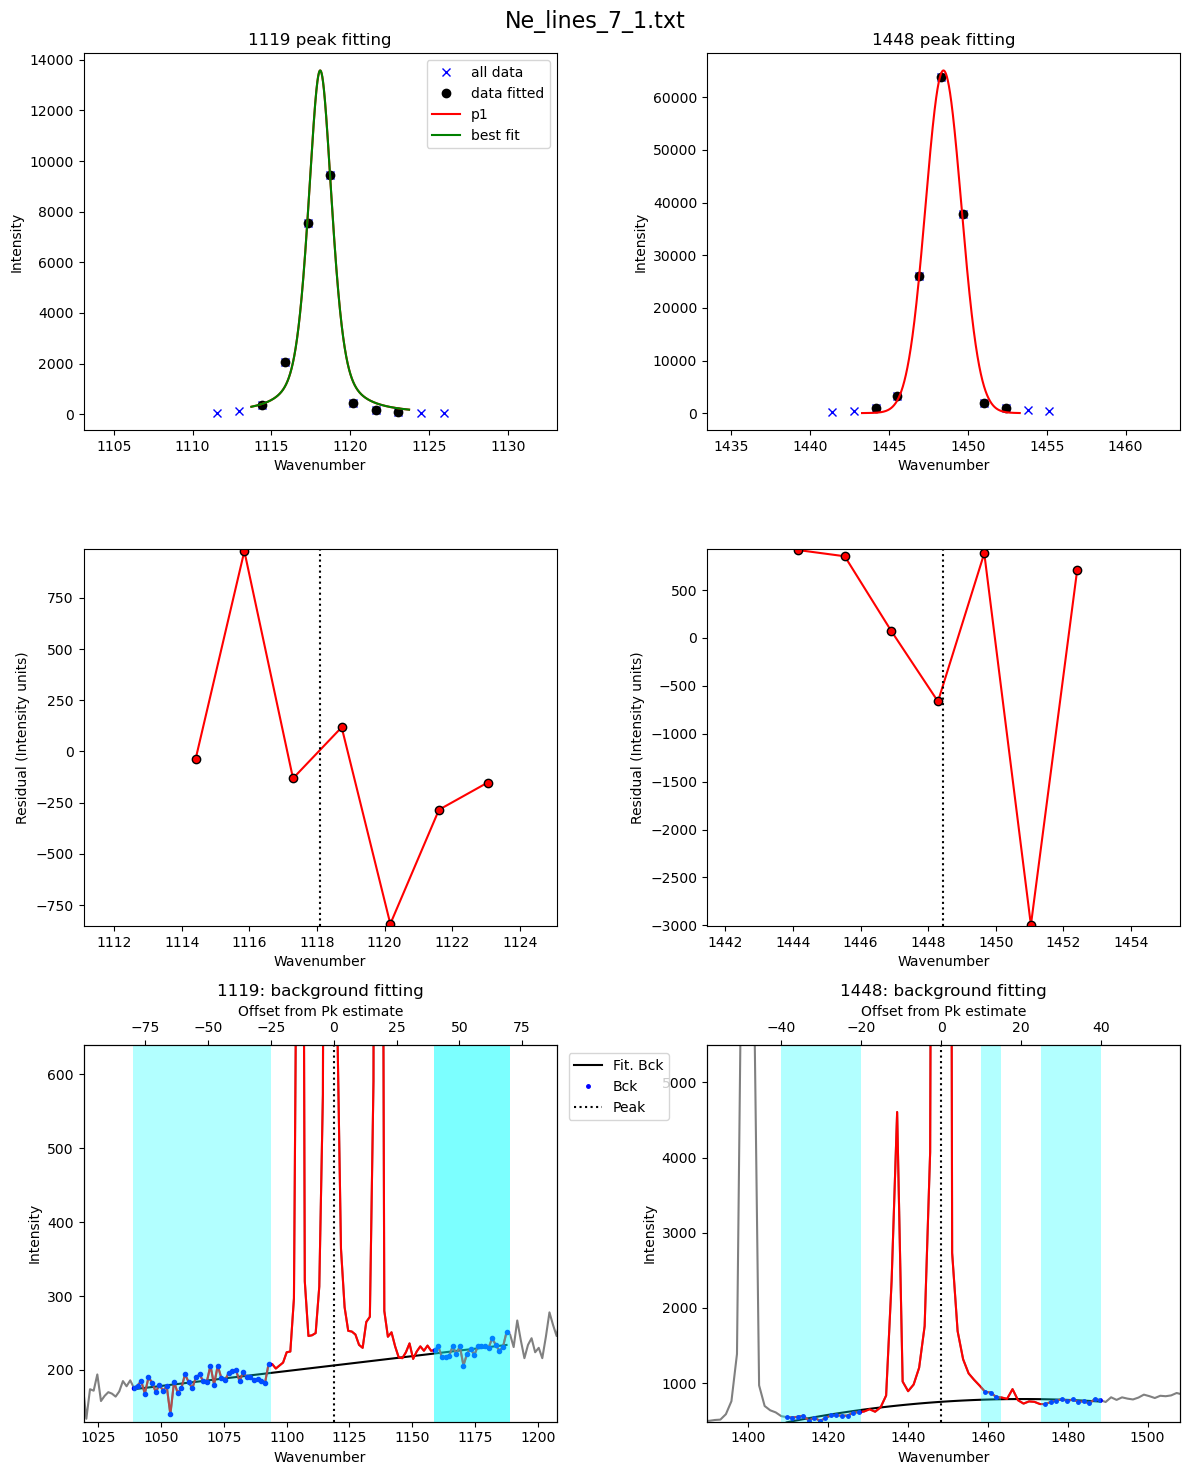

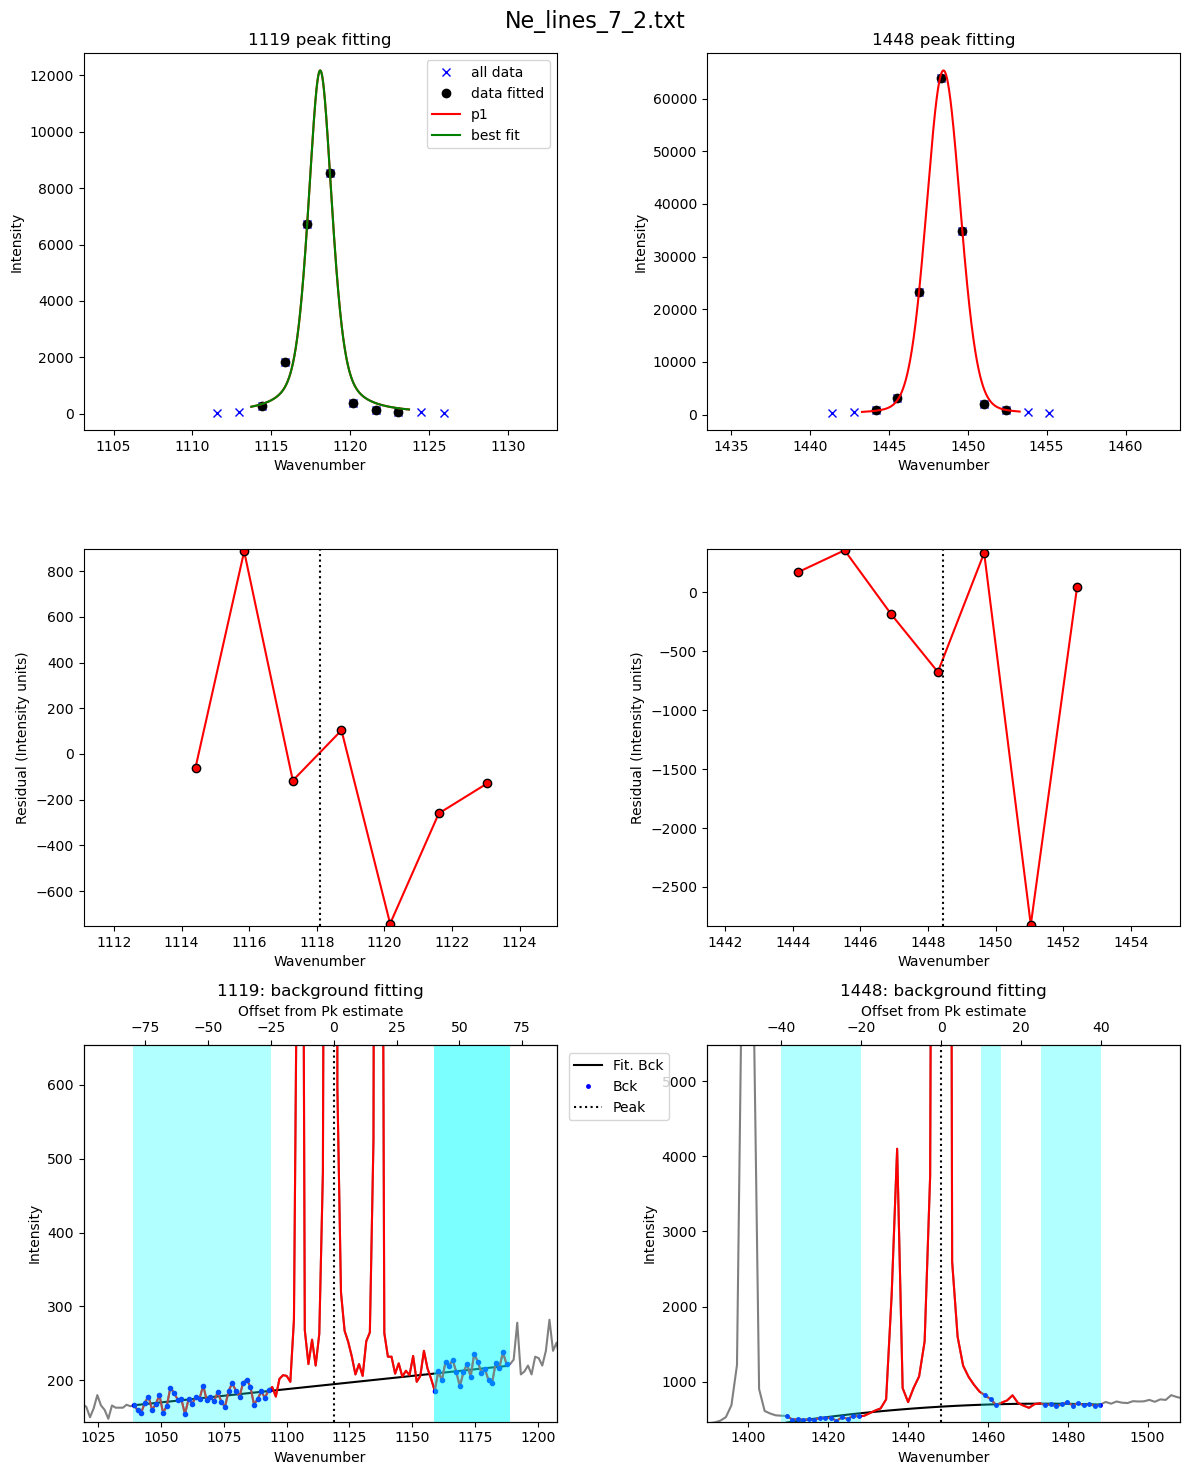

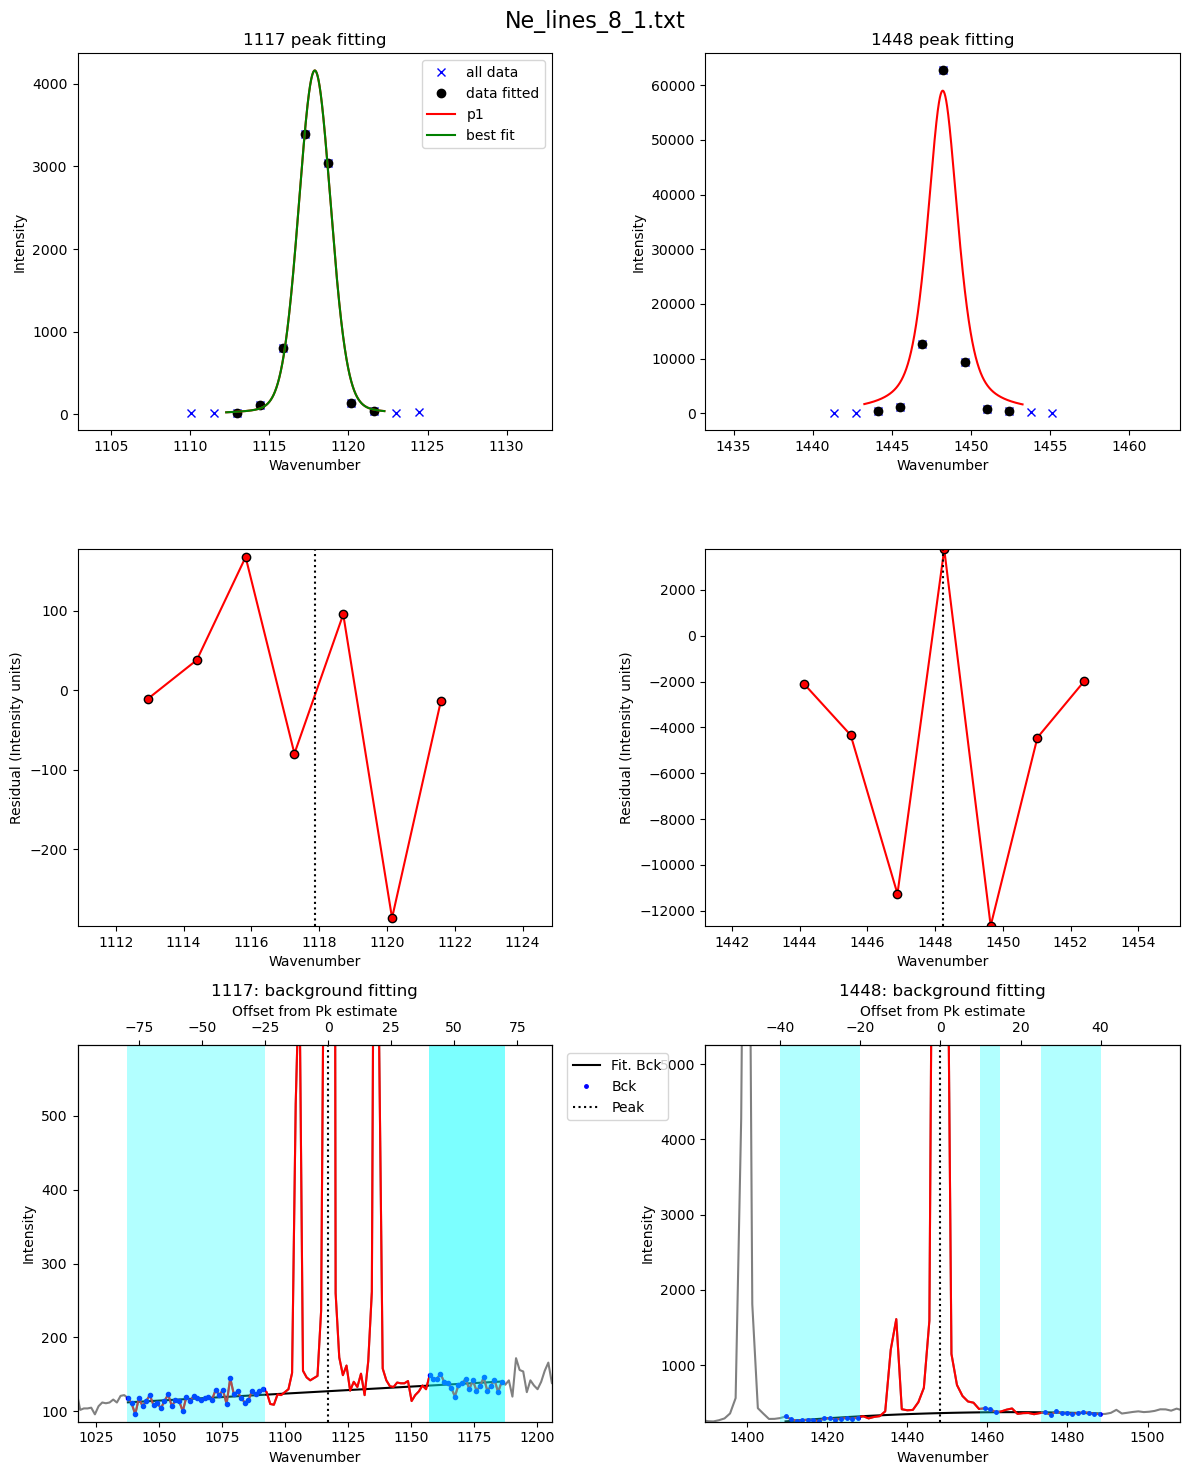

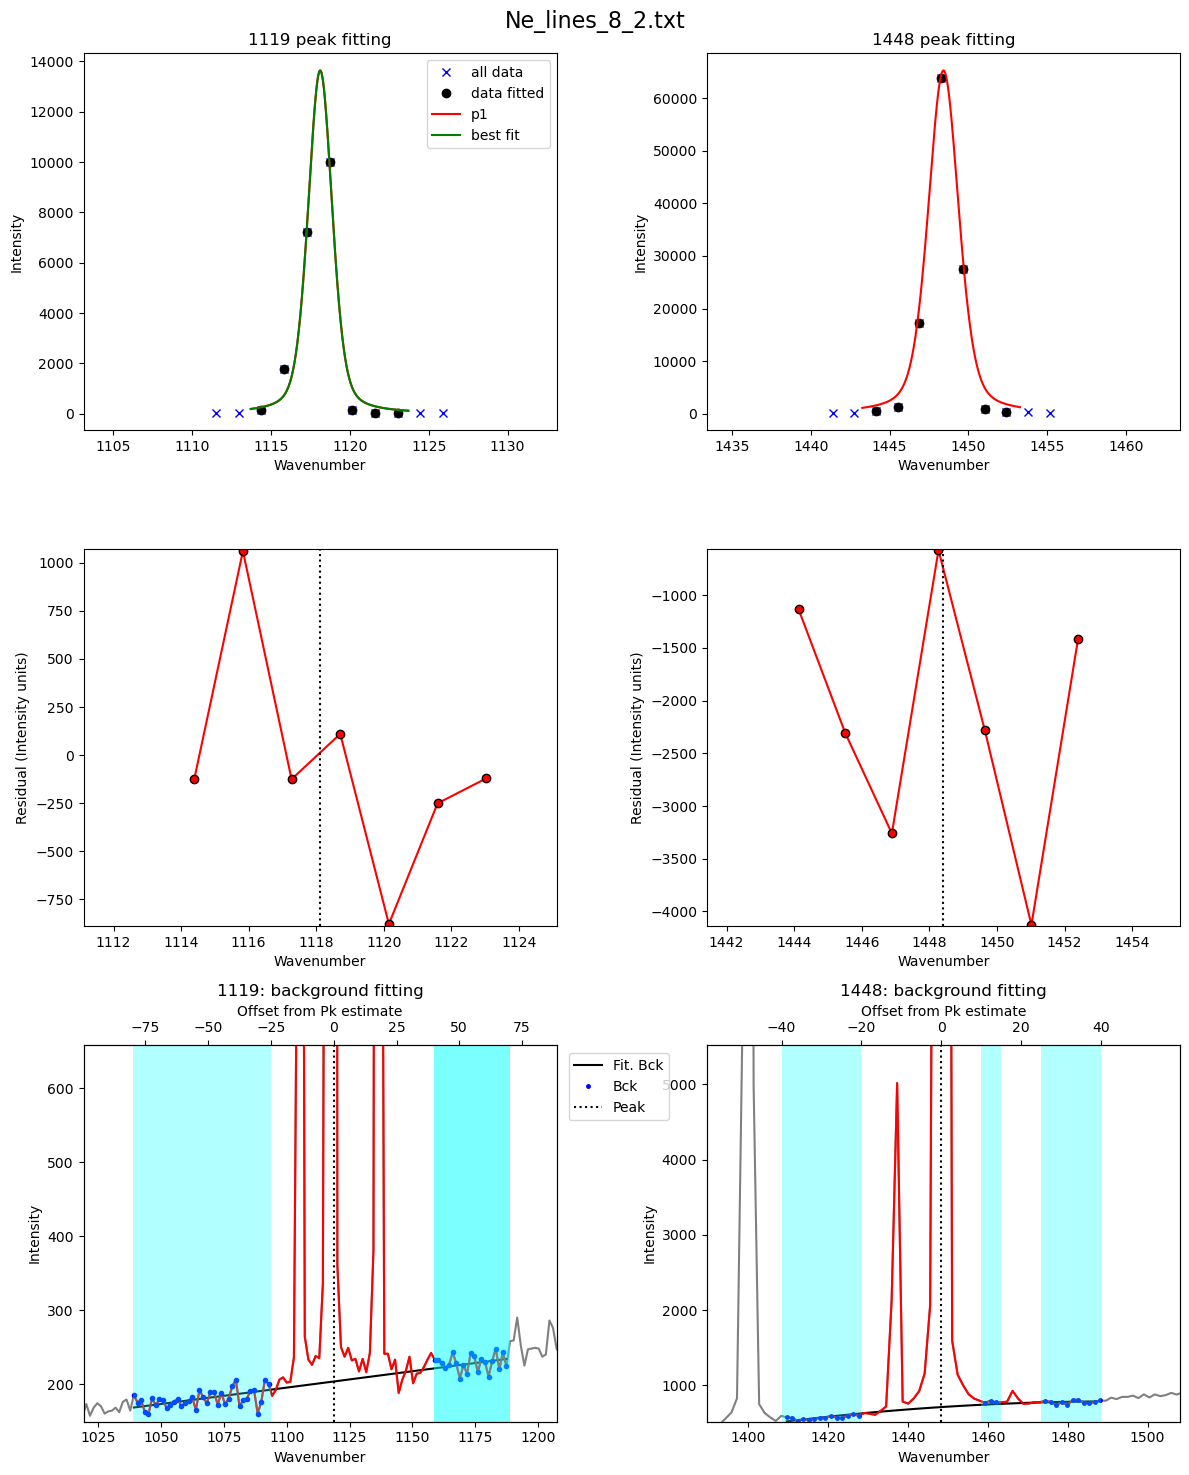

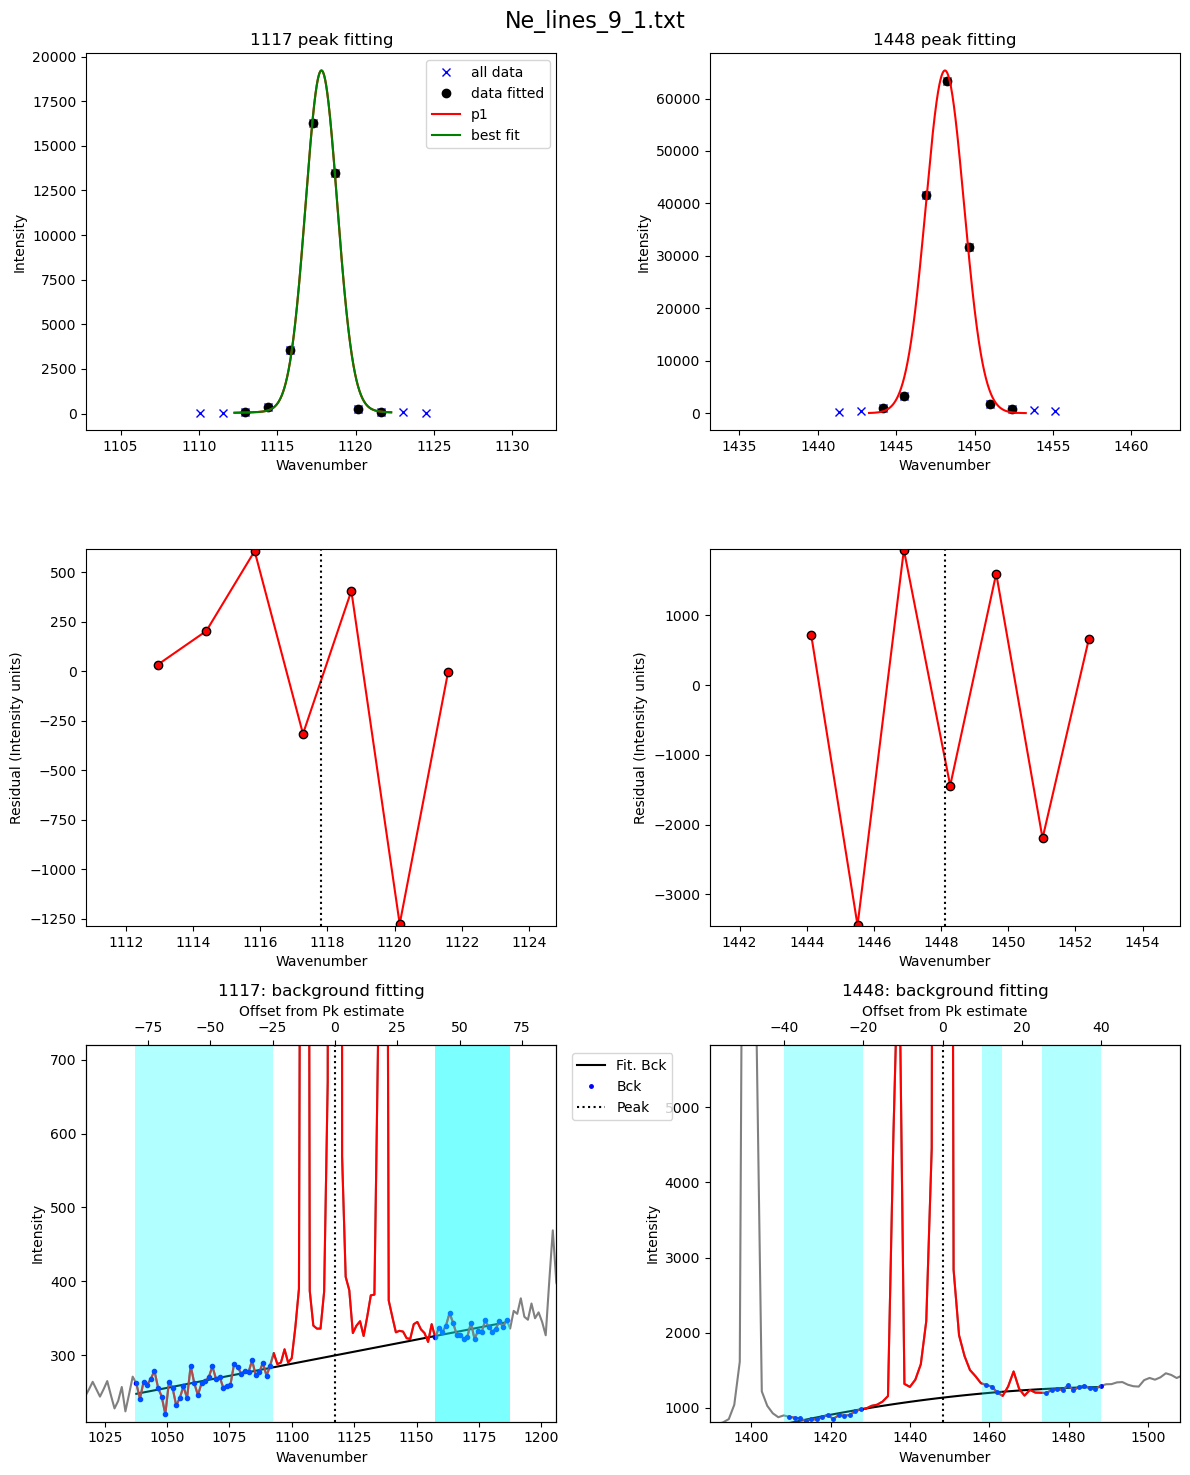

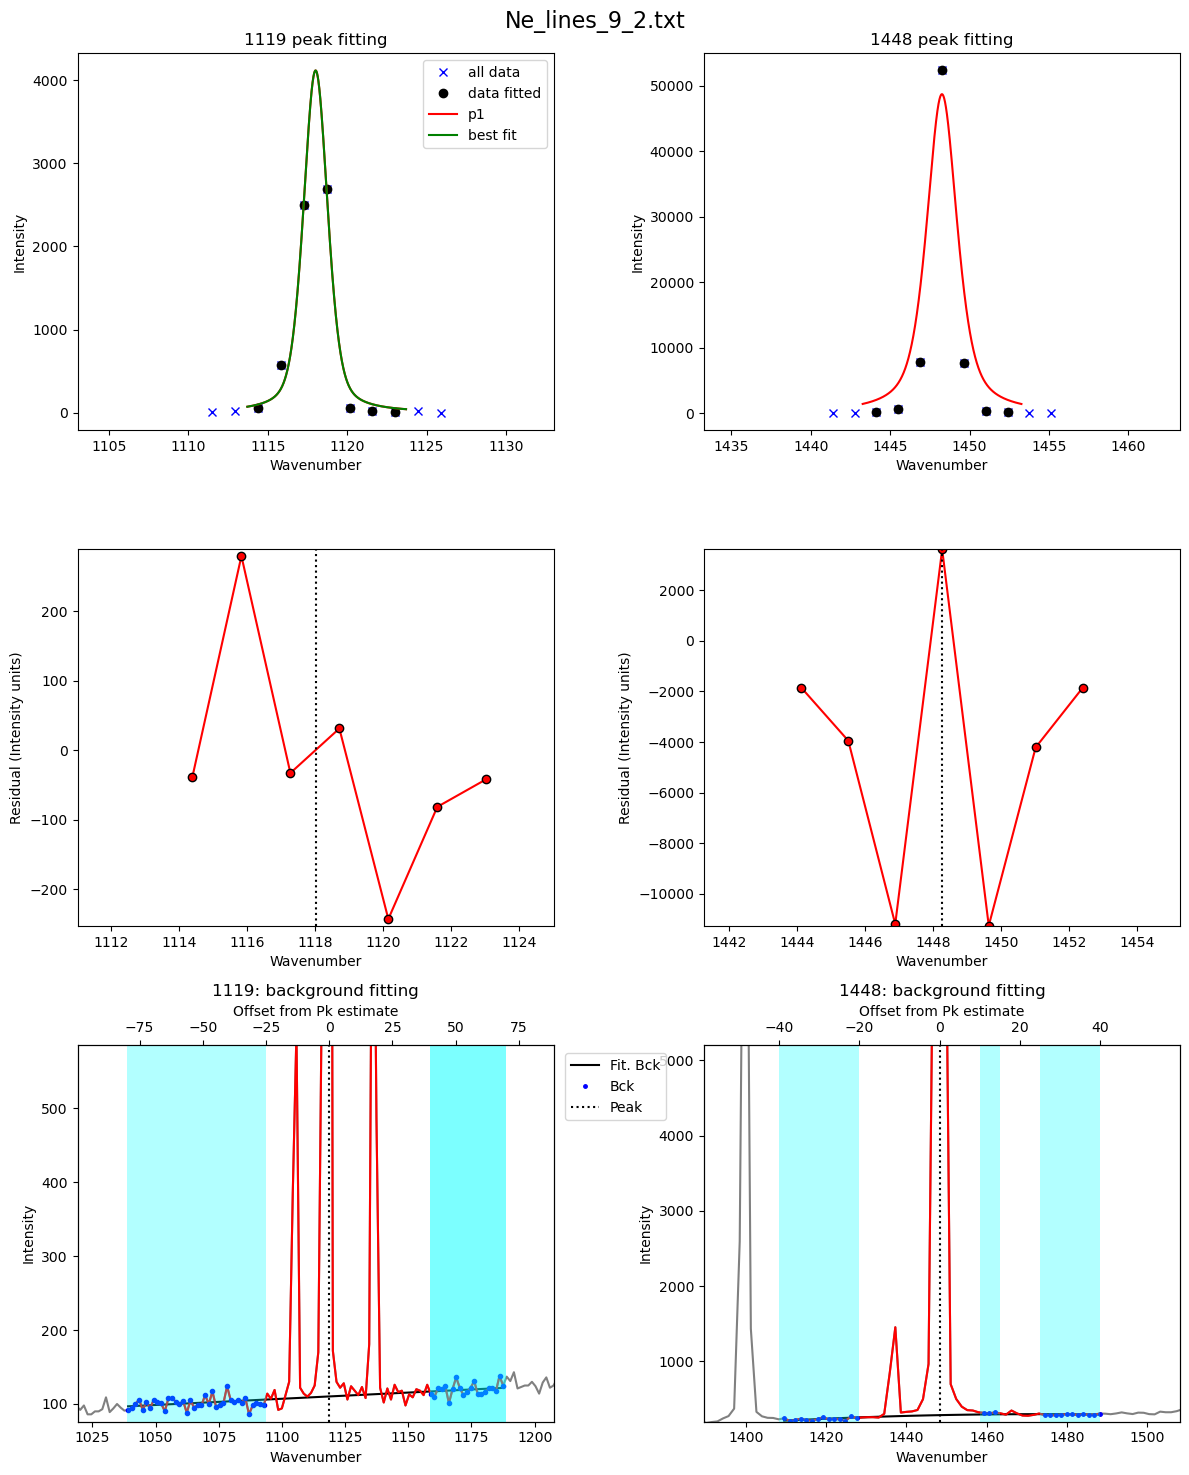

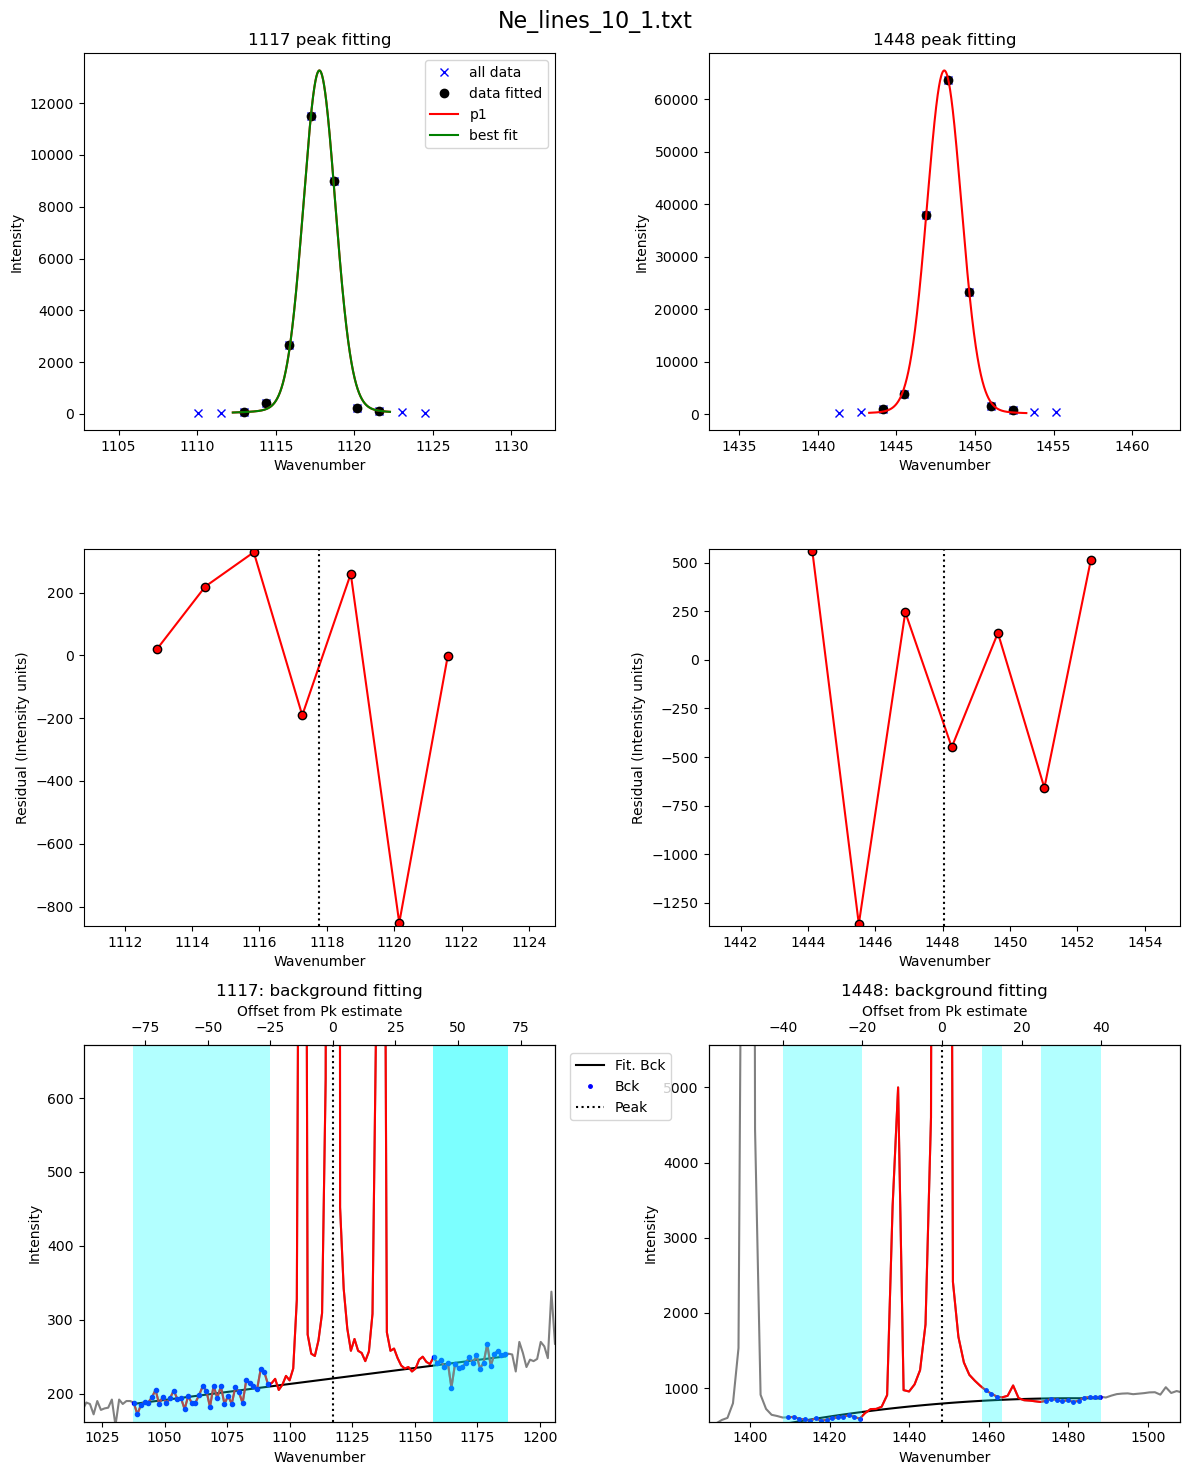

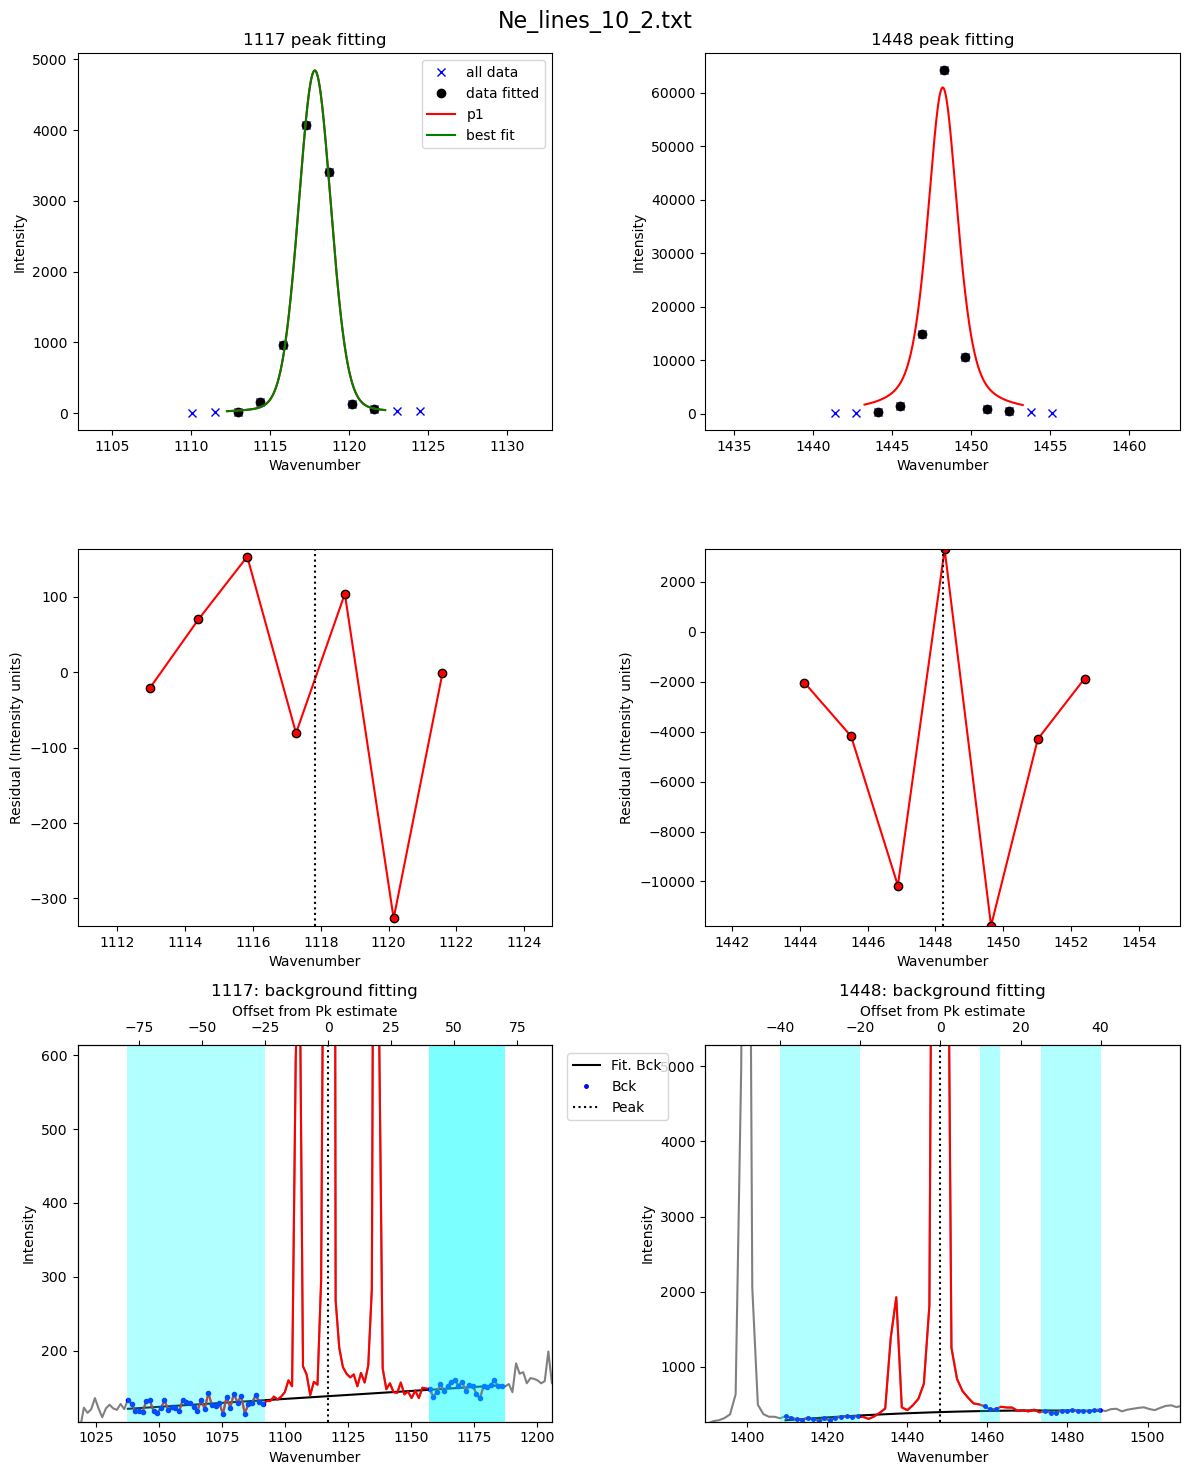

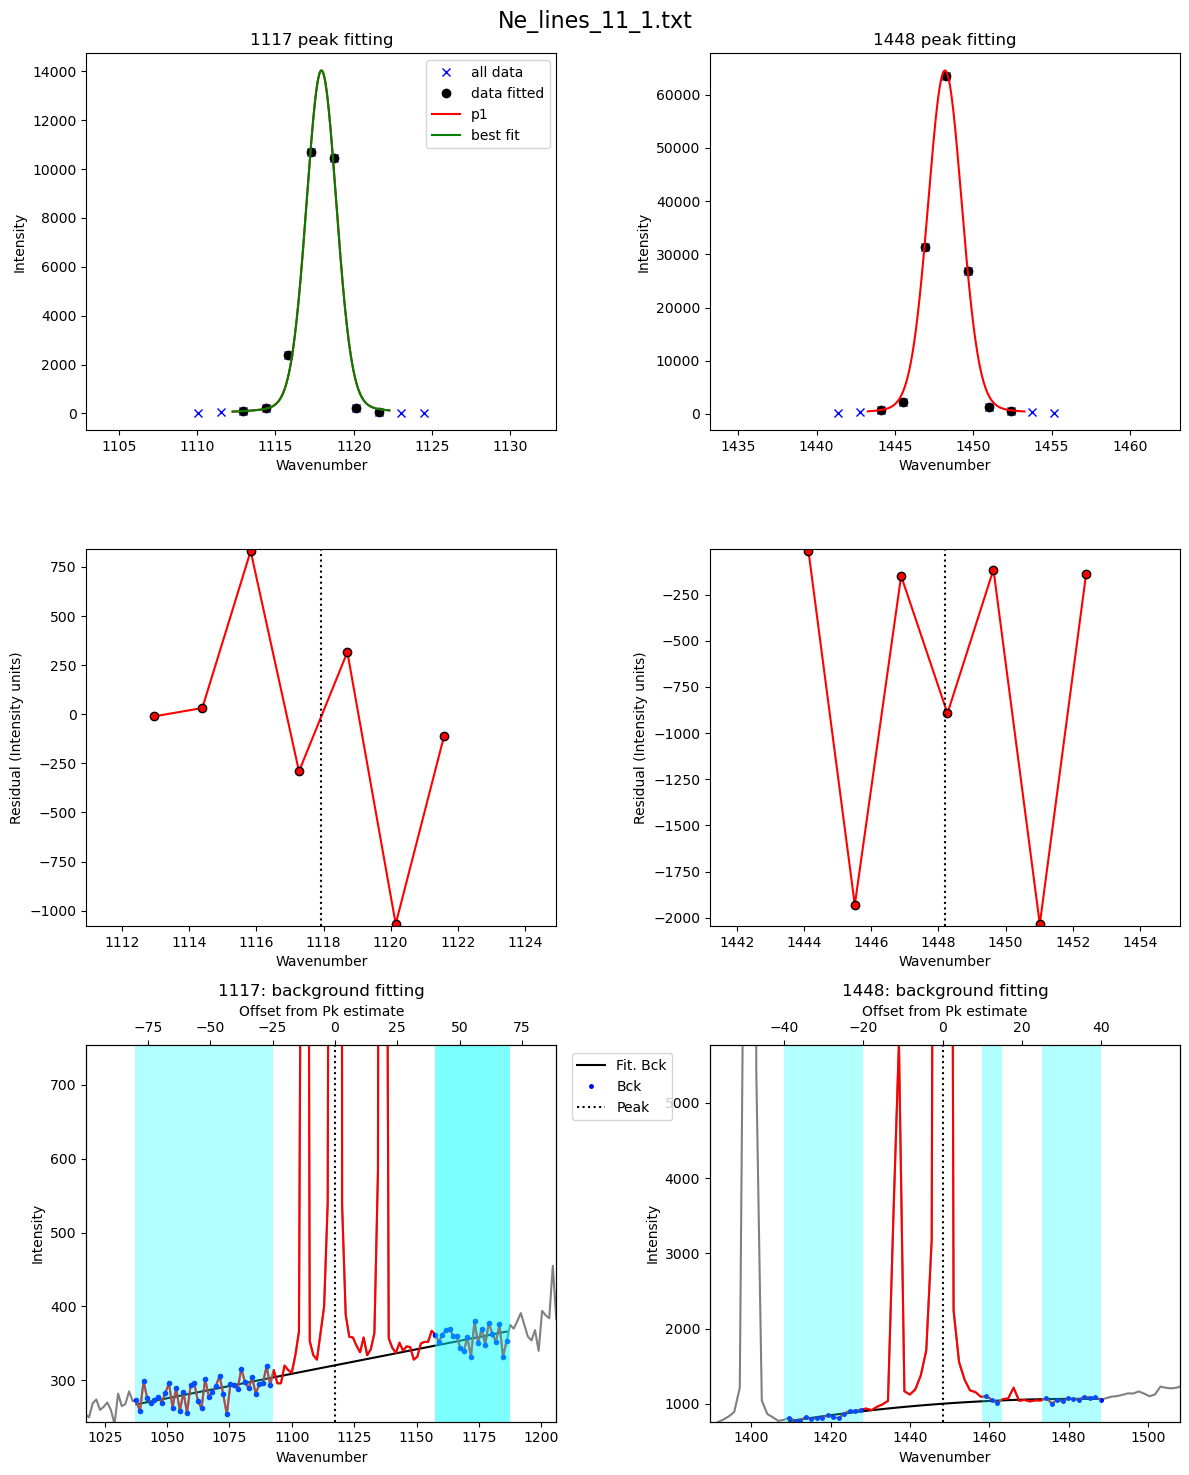

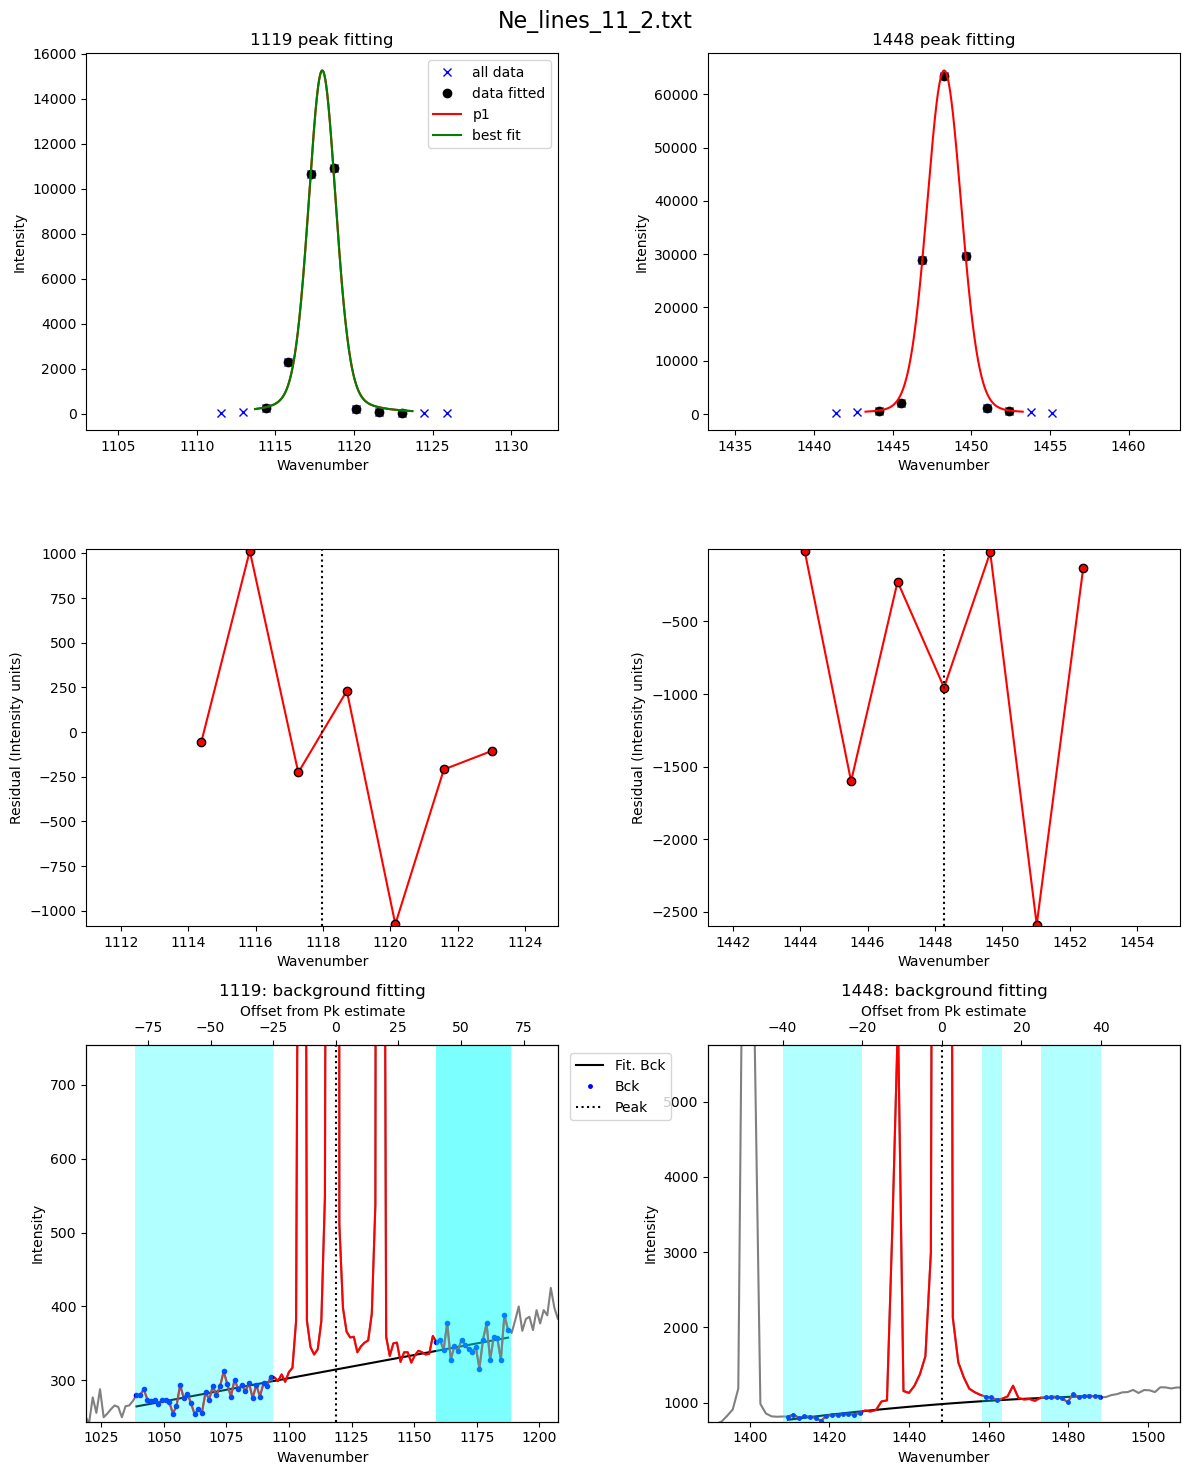

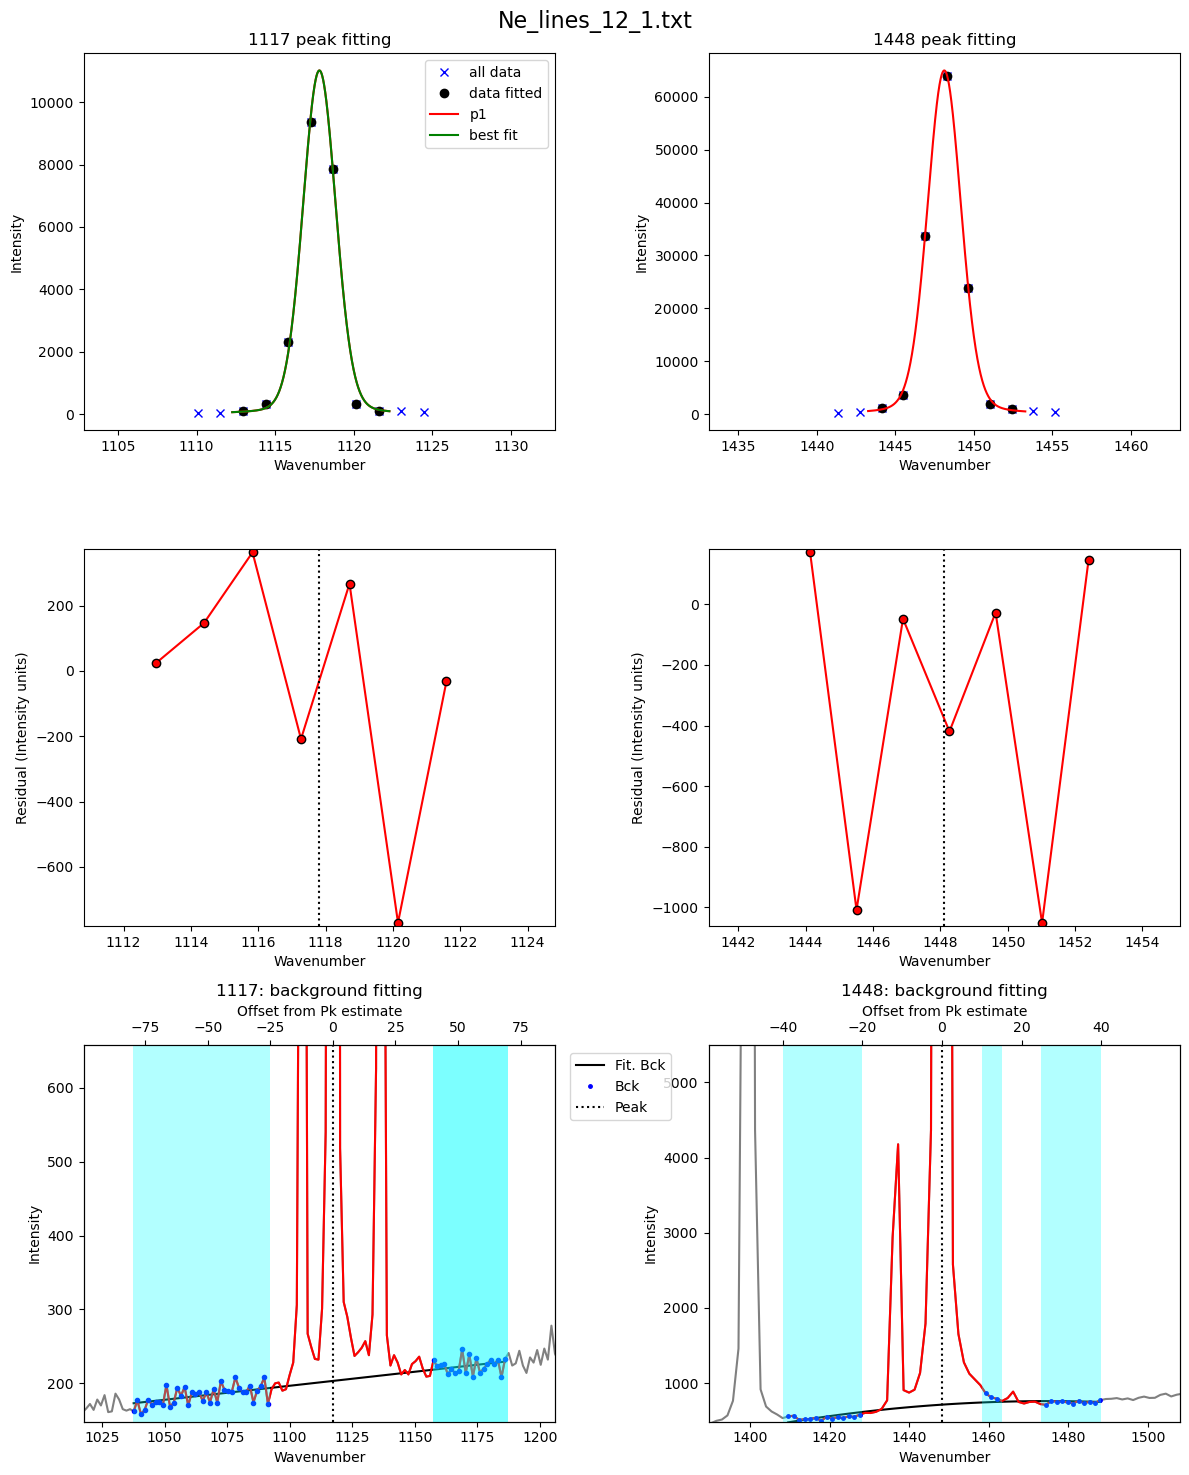

In [31]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_tweak,
df_fit_params=df_fit_params,                    
plot_figure=True)

In [32]:
df2

filename   Ne_Corr     deltaNe  pk2_peak_cent  pk1_peak_cent  \
0   Ne_lines_12_2.txt  1.000098  330.445113    1448.553879    1118.108766   
1    Ne_lines_1_1.txt  1.001157  330.095758    1447.744338    1117.648580   
2    Ne_lines_1_2.txt  1.000362  330.358091    1448.517749    1118.159658   
3    Ne_lines_2_1.txt  1.001203  330.080409    1448.044888    1117.964479   
4    Ne_lines_2_2.txt  1.000463  330.324607    1448.386875    1118.062268   
5    Ne_lines_3_1.txt  1.001019  330.141334    1448.136827    1117.995493   
6    Ne_lines_3_2.txt  1.000416  330.340211    1448.321953    1117.981742   
7    Ne_lines_4_1.txt  1.000438  330.332860    1448.280387    1117.947527   
8    Ne_lines_4_2.txt  1.000247  330.396184    1448.539552    1118.143367   
9    Ne_lines_5_1.txt  1.000147  330.428933    1448.664948    1118.236015   
10   Ne_lines_5_2.txt  1.000270  330.388346    1448.599158    1118.210812   
11   Ne_lines_6_1.txt  1.000302  330.377954    1448.490884    1118.112930   
12   Ne_lines_6_2.txt  1.000312  330.374578    1448.481721    1118.107143   
13   Ne_lines_7_1.txt  1.000362  330.357968    1448.452335    1118.094368   
14   Ne_lines_7_2.txt  1.000369  330.355613    1448.455617    1118.100004   
15   Ne_lines_8_1.txt  1.000371  330.355057    1448.225771    1117.870714   
16   Ne_lines_8_2.txt  1.000536  330.300754    1448.417169    1118.116414   
17   Ne_lines_9_1.txt  1.000556  330.293921    1448.113653    1117.819732   
18   Ne_lines_9_2.txt  1.000682  330.252453    1448.263368    1118.010915   
19  Ne_lines_10_1.txt  1.000630  330.269447    1448.047775    1117.778327   
20  Ne_lines_10_2.txt  1.000263  330.390630    1448.213852    1117.823222   
21  Ne_lines_11_1.txt  1.000668  330.257039    1448.195286    1117.938247   
22  Ne_lines_11_2.txt  1.000562  330.292059    1448.272797    1117.980738   
23  Ne_lines_12_1.txt  1.000538  330.299976    1448.115532    1117.815556   

    pk2_amplitude  pk1_amplitude  residual_pk2  residual_pk1  pk2_sigma  \
0   201929.371766   50277.475601   2318.612252    588.804541   1.401790   
1   215902.704359   46565.179158   2838.930969    207.431036   1.353410   
2   213799.956155   48427.850842   3050.192072    553.925181   1.480903   
3   200968.945307   39896.847789   1674.821468    426.372427   1.427475   
4   215030.723707   60122.064374   3010.880740    702.670977   1.519435   
5   186270.250265   24003.805964   1314.630491    258.456060   1.141976   
6   220569.355540   55927.525358   3180.623099    610.063060   1.552060   
7   194207.075209   38832.860199   1145.337601    421.711455   1.416069   
8   186359.834023   38529.350150    828.911292    468.142864   1.252851   
9   186386.216410   33045.993552   1105.549578    423.826947   1.141976   
10  186448.838025   30950.931615   1429.117014    394.763762   1.141976   
11  186540.161407   27275.074877   1662.069073    328.589032   1.141976   
12  186565.383927   25867.160246   1316.851093    290.431075   1.141976   
13  186354.325634   32615.637717   1013.880014    363.031545   1.338557   
14  186429.413680   29027.118589    656.296274    327.824321   1.259298   
15  182380.747411   11320.022106   5790.793181     98.611195   1.141976   
16  186410.859122   30483.449152   2156.608406    381.443560   1.141976   
17  200343.990405   50301.611845   1714.593737    406.392912   1.439798   
18  152144.037686    9455.869700   5421.787226    106.765779   1.141976   
19  186331.132414   35578.922299    561.352919    267.589113   1.297539   
20  186626.556069   13225.236488   5373.442606    108.105052   1.141976   
21  186098.330478   36204.842464    753.356965    379.900373   1.282290   
22  186075.427175   37777.362221    790.727413    416.236010   1.288303   
23  186380.418008   30474.642965    410.268916    258.727033   1.259764   

   pk2_gamma  error_pk2  Peak2_Prop_Lor  pk1_sigma pk1_gamma  error_pk1  \
0       None          1    1.977162e-10   0.902809      None     0.0707   
1       None          1    1.459106e-09   1.162319      None 

## Now extract metadata to get a timestamp for each file

## Get time stamp
- Unlike WITEc, some Ramans do not output datafiles. Here, we use the modification or creation time of the file to get the time the spectra was acquired (if the instrument creates the file after each acquisition, as on this c.2008 HORIBA)



In [33]:
meta=pf.loop_convert_datastamp_to_metadata(path=spectra_path, 
files=Ne_files, creation=False,
modification=True)

In [34]:
meta['filename'].values

array(['Ne_lines_1_1.txt', 'Ne_lines_1_2.txt', 'Ne_lines_2_1.txt',
       'Ne_lines_2_2.txt', 'Ne_lines_3_1.txt', 'Ne_lines_3_2.txt',
       'Ne_lines_4_1.txt', 'Ne_lines_4_2.txt', 'Ne_lines_6_1.txt',
       'Ne_lines_6_2.txt', 'Ne_lines_5_1.txt', 'Ne_lines_5_2.txt',
       'Ne_lines_7_1.txt', 'Ne_lines_7_2.txt', 'Ne_lines_8_1.txt',
       'Ne_lines_8_2.txt', 'Ne_lines_9_1.txt', 'Ne_lines_9_2.txt',
       'Ne_lines_10_1.txt', 'Ne_lines_10_2.txt', 'Ne_lines_11_1.txt',
       'Ne_lines_11_2.txt', 'Ne_lines_12_1.txt', 'Ne_lines_12_2.txt'],
      dtype=object)

In [35]:
# Strip away suffix and prefix if needed
print(meta['filename'][0])

0     Ne_lines_1_1.txt
0     Ne_lines_1_2.txt
0     Ne_lines_2_1.txt
0     Ne_lines_2_2.txt
0     Ne_lines_3_1.txt
0     Ne_lines_3_2.txt
0     Ne_lines_4_1.txt
0     Ne_lines_4_2.txt
0     Ne_lines_6_1.txt
0     Ne_lines_6_2.txt
0     Ne_lines_5_1.txt
0     Ne_lines_5_2.txt
0     Ne_lines_7_1.txt
0     Ne_lines_7_2.txt
0     Ne_lines_8_1.txt
0     Ne_lines_8_2.txt
0     Ne_lines_9_1.txt
0     Ne_lines_9_2.txt
0    Ne_lines_10_1.txt
0    Ne_lines_10_2.txt
0    Ne_lines_11_1.txt
0    Ne_lines_11_2.txt
0    Ne_lines_12_1.txt
0    Ne_lines_12_2.txt
Name: filename, dtype: object


In [36]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'][0],
    prefix=False, str_prefix=None,
   file_type='.txt')
file_m

array(['Ne_lines_1_1', 'Ne_lines_1_2', 'Ne_lines_2_1', 'Ne_lines_2_2',
       'Ne_lines_3_1', 'Ne_lines_3_2', 'Ne_lines_4_1', 'Ne_lines_4_2',
       'Ne_lines_6_1', 'Ne_lines_6_2', 'Ne_lines_5_1', 'Ne_lines_5_2',
       'Ne_lines_7_1', 'Ne_lines_7_2', 'Ne_lines_8_1', 'Ne_lines_8_2',
       'Ne_lines_9_1', 'Ne_lines_9_2', 'Ne_lines_10_1', 'Ne_lines_10_2',
       'Ne_lines_11_1', 'Ne_lines_11_2', 'Ne_lines_12_1', 'Ne_lines_12_2'],
      dtype=object)

In [37]:
# Do the same for spectra, e.g., work out what you need to strip off
print(df2['filename'][0])

Ne_lines_12_2.txt


In [38]:
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False, str_prefix=' ',
   file_type='.txt')
file_s

array(['Ne_lines_12_2', 'Ne_lines_1_1', 'Ne_lines_1_2', 'Ne_lines_2_1',
       'Ne_lines_2_2', 'Ne_lines_3_1', 'Ne_lines_3_2', 'Ne_lines_4_1',
       'Ne_lines_4_2', 'Ne_lines_5_1', 'Ne_lines_5_2', 'Ne_lines_6_1',
       'Ne_lines_6_2', 'Ne_lines_7_1', 'Ne_lines_7_2', 'Ne_lines_8_1',
       'Ne_lines_8_2', 'Ne_lines_9_1', 'Ne_lines_9_2', 'Ne_lines_10_1',
       'Ne_lines_10_2', 'Ne_lines_11_1', 'Ne_lines_11_2', 'Ne_lines_12_1'],
      dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [39]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [40]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

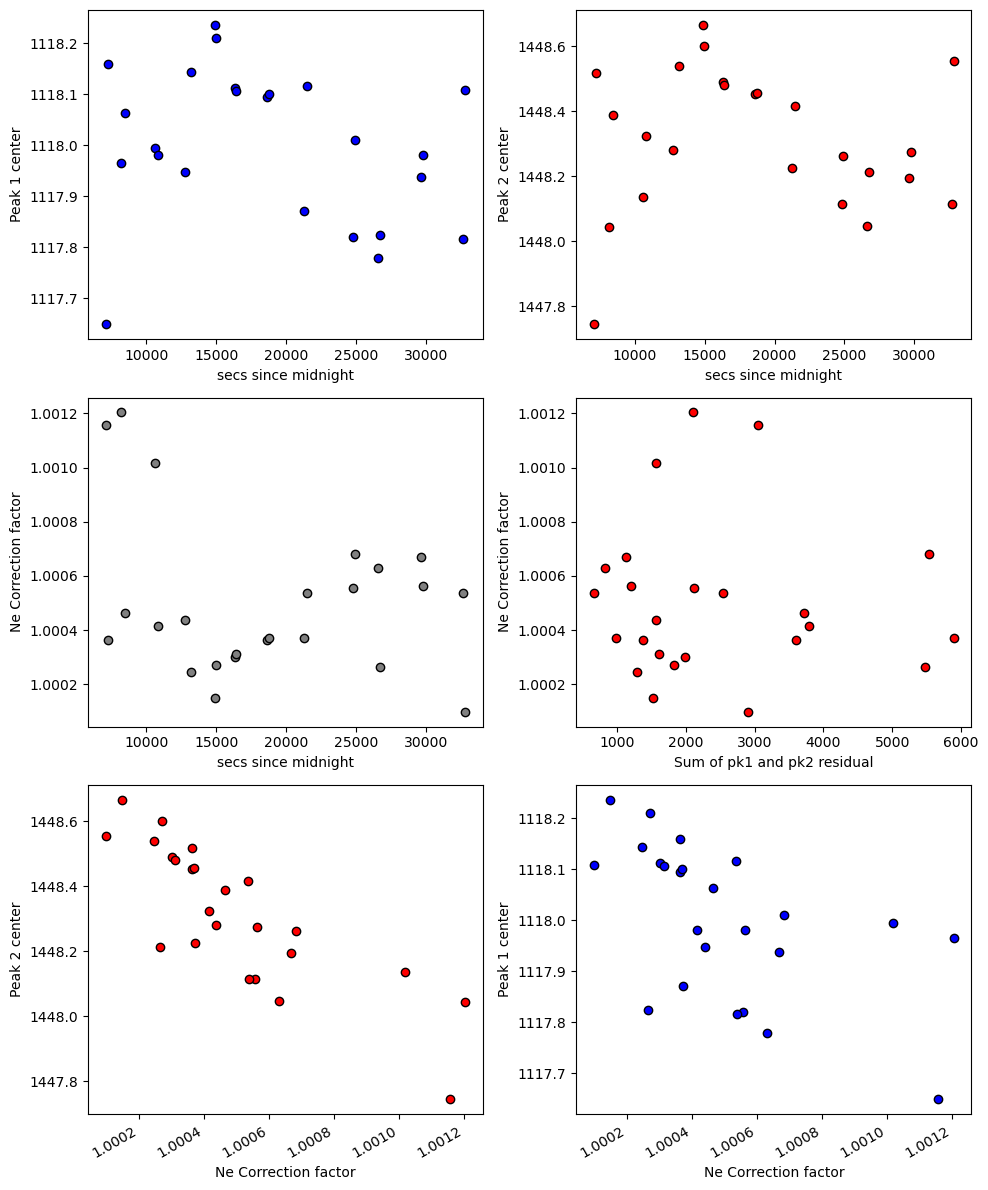

In [41]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [42]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo

filename_x   Ne_Corr     deltaNe  pk2_peak_cent  pk1_peak_cent  \
0   Ne_lines_12_2.txt  1.000098  330.445113    1448.553879    1118.108766   
1    Ne_lines_1_1.txt  1.001157  330.095758    1447.744338    1117.648580   
2    Ne_lines_1_2.txt  1.000362  330.358091    1448.517749    1118.159658   
3    Ne_lines_2_1.txt  1.001203  330.080409    1448.044888    1117.964479   
4    Ne_lines_2_2.txt  1.000463  330.324607    1448.386875    1118.062268   
5    Ne_lines_3_1.txt  1.001019  330.141334    1448.136827    1117.995493   
6    Ne_lines_3_2.txt  1.000416  330.340211    1448.321953    1117.981742   
7    Ne_lines_4_1.txt  1.000438  330.332860    1448.280387    1117.947527   
8    Ne_lines_4_2.txt  1.000247  330.396184    1448.539552    1118.143367   
9    Ne_lines_5_1.txt  1.000147  330.428933    1448.664948    1118.236015   
10   Ne_lines_5_2.txt  1.000270  330.388346    1448.599158    1118.210812   
11   Ne_lines_6_1.txt  1.000302  330.377954    1448.490884    1118.112930   
12   Ne_lines_6_2.txt  1.000312  330.374578    1448.481721    1118.107143   
13   Ne_lines_7_1.txt  1.000362  330.357968    1448.452335    1118.094368   
14   Ne_lines_7_2.txt  1.000369  330.355613    1448.455617    1118.100004   
15   Ne_lines_8_1.txt  1.000371  330.355057    1448.225771    1117.870714   
16   Ne_lines_8_2.txt  1.000536  330.300754    1448.417169    1118.116414   
17   Ne_lines_9_1.txt  1.000556  330.293921    1448.113653    1117.819732   
18   Ne_lines_9_2.txt  1.000682  330.252453    1448.263368    1118.010915   
19  Ne_lines_10_1.txt  1.000630  330.269447    1448.047775    1117.778327   
20  Ne_lines_10_2.txt  1.000263  330.390630    1448.213852    1117.823222   
21  Ne_lines_11_1.txt  1.000668  330.257039    1448.195286    1117.938247   
22  Ne_lines_11_2.txt  1.000562  330.292059    1448.272797    1117.980738   
23  Ne_lines_12_1.txt  1.000538  330.299976    1448.115532    1117.815556   

    pk2_amplitude  pk1_amplitude  residual_pk2  residual_pk1  pk2_sigma  ...  \
0   201929.371766   50277.475601   2318.612252    588.804541   1.401790  ...   
1   215902.704359   46565.179158   2838.930969    207.431036   1.353410  ...   
2   213799.956155   48427.850842   3050.192072    553.925181   1.480903  ...   
3   200968.945307   39896.847789   1674.821468    426.372427   1.427475  ...   
4   215030.723707   60122.064374   3010.880740    702.670977   1.519435  ...   
5   186270.250265   24003.805964   1314.630491    258.456060   1.141976  ...   
6   220569.355540   55927.525358   3180.623099    610.063060   1.552060  ...   
7   194207.075209   38832.860199   1145.337601    421.711455   1.416069  ...   
8   186359.834023   38529.350150    828.911292    468.142864   1.252851  ...   
9   186386.216410   33045.993552   1105.549578    423.826947   1.141976  ...   
10  186448.838025   30950.931615   1429.117014    394.763762   1.141976  ...   
11  186540.161407   27275.074877   1662.069073    328.589032   1.141976  ...   
12  186565.383927   25867.160246   1316.851093    290.431075   1.141976  ...   
13  186354.325634   32615.637717   1013.880014    363.031545   1.338557  ...   
14  186429.413680   29027.118589    656.296274    327.824321   1.259298  ...   
15  182380.747411   11320.022106   5790.793181     98.611195   1.141976  ...   
16  186410.859122   30483.449152   2156.608406    381.443560   1.141976  ...   
17  200343.990405   50301.611845   1714.593737    406.392912   1.439798  ...   
18  152144.037686    9455.869700   5421.787226    106.765779   1.141976  ...   
19  186331.132414   35578.922299    561.352919    267.589113   1.297539  ...   
20  186626.556069   13225.236488   5373.442606    108.105052   1.141976  ...   
21  186098.330478   36204.842464    753.356965    379.900373   1.282290  ...   
22  186075.427175   37777.362221    790.727413    416.236010   1.288303  ...   
23  186380.418008   30474.642965    410.268916    258.727033   1.259764  ...   

      Month  Day  power (mW)  Int_time (s) accumulations  Mag (X)  duration  \
0   J

In [43]:
df_combo_sort.to_clipboard(excel=True)

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- E.g. only taking ones within median+-offset. 

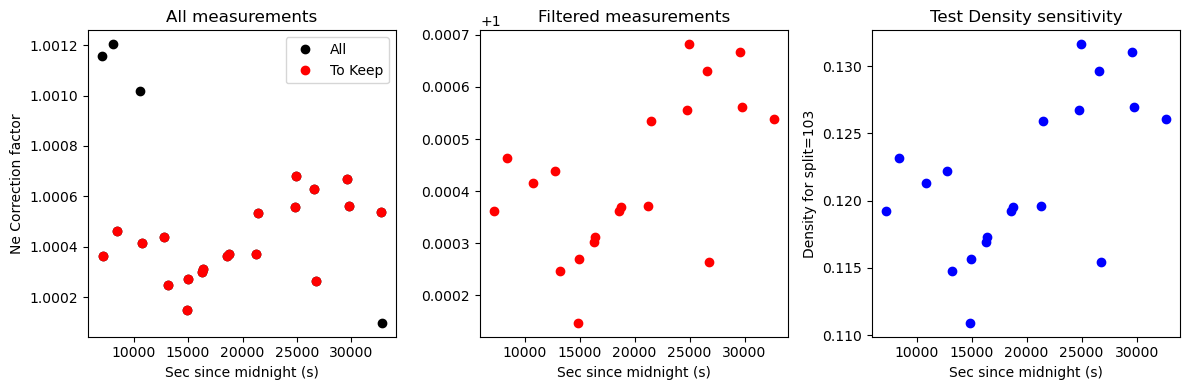

In [64]:
filt=pf.filter_Ne_Line_neighbours(Corr_factor=df_combo['Ne_Corr'], 
                    number_av=6, offset=0.0004)
# Now lets plot this to see
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='All')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='To Keep')
ax1.legend()
ax2.plot(df_combo['sec since midnight'], filt,  'or', label='To Keep')

test_split=103
split=filt*test_split
density_test=pf.calculate_density_cornell(temp='SupCrit', Split=split)
ax3.plot(df_combo['sec since midnight'].loc[density_test['Preferred D']>0],
         density_test['Preferred D'].loc[density_test['Preferred D']>0], 'ob')


ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')
ax2.set_xlabel('Sec since midnight (s)')
ax2.set_title('Filtered measurements')
ax3.set_xlabel('Sec since midnight (s)')
ax3.set_ylabel('Density for split=' + str(test_split))
ax3.set_title('Test Density sensitivity')
fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

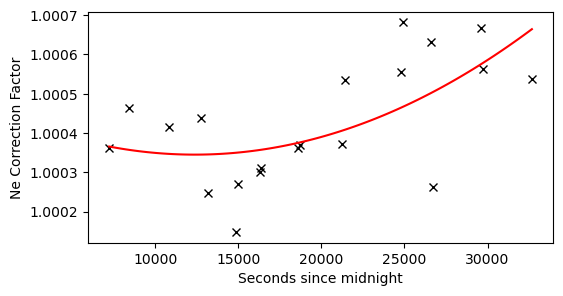

In [82]:
df_combo_filt=df_combo[density_test['Preferred D']>0]
model, fig=pf.reg_Ne_lines_time(df=df_combo_filt, fit='poly', N_poly=2)

## SAving as pickle, can then load as a pickle

In [83]:
import pickle
with open('Ne_Line_Regression_Example_cali.pck', 'wb') as file_handle:
    pickle.dump(model, file_handle)